Original Graph Memory Code:

https://arxiv.org/abs/2407.04363

https://github.com/AIRI-Institute/AriGraph/tree/main


# Memory

## Prompts

In [11]:
# prompts.py

prompt_refining_items = """You will be provided with list of existing triplets and list of new triplets. Triplets are in the following format: "subject, relation, object".
The triplets denote facts about the environment where the player moves. The player takes actions and the environment changes, so some triplets from the list of existing triplets can be replaced with one of the new triplets. For example, the player took the item from the locker and the existing triplet "item, is in, locker" should be replaced with the new triplet "item, is in, inventory".

Sometimes there are no triplets to replace:
Example of existing triplets: "Golden locker, state, open"; "Room K, is west of, Room I"; "Room K, has exit, east".
Example of new triplets: "Room T, is north of, Room N"; "Room T, has exit, south".
Example of replacing: []. Nothisg to replace here

Sometimes several triplets can be replaced with one:
Example of existing triplets: "kitchen, contains, broom"; "broom, is on, floor".
Example of new triplets: "broom, is in, inventory".
Example of replacing: [["kitchen, contains, broom" -> "broom, is in, inventory"], ["broom, is on, floor" -> "broom, is in, inventory"]]. Because broom changed location from the floor in the kitchen to players inventory.

Ensure that triplets are only replaced if they contain redundant or conflicting information about the same aspect of an entity. Triplets should not be replaced if they provide distinct or complementary information about entities compared to the new triplets. Specifically, consider the relationships, properties, or contexts described by each triplet and verify that they align before replacement. If there is uncertainty about whether a triplet should be replaced, prioritize retaining the existing triplet over replacing it. When comparing existing and new triplets, if they refer to different aspects or attributes of entities, do not replace them. Replacements should only occur when there is semantic duplication between an existing triplet and a new triplet.
Example of existing triplets: "apple, to be, cooked", 'knife, used for, cutting', 'apple, has been, sliced'
Example of new triplets: "apple, is on, table", 'kitchen, contsins, knife', 'apple, has beed, grilled'.
Example of replacing: []. Nothing to replace here. These triplets describe different properties of items, so they should not be replaced.

Another example of when not to replase existung triplets:
Example of existing triplets: "brush, used for, painting".
Example of new triplets: "brush, is in, art class".
Example of replacing: []. Nothing to replace here. These triplets describe different properties of brush, so they should not be replaced.

I repeat, do not replace triplets, if they carry differend type of information about entities!!! It is better to leave a tripplet, than to replace the one that has important information. Do not state that triplet needs to be replaced if you are not sure!!!
If you find triplet in Existing triplets which semantically duplicate some triplet in New triplets, replace such triplet from Existing triplets. However do not replace triplets if they refer to different things.
####

Generate only replacing, no descriptions are needed.
Existing triplets: {ex_triplets}.
New triplets: {new_triplets}.
####
Warning! Replacing must be generated strictly in following format: [[outdated_triplet_1 -> actual_triplet_1], [outdated_triplet_2 -> actual_triplet_2], ...], you MUST NOT include any descriptions in answer.
Replacing: """

prompt_extraction_current = '''Objective: The main goal is to meticulously gather information from game observations and organize this data into a clear, structured knowledge graph.

Guidelines for Building the Knowledge Graph:

Creating Nodes and Triplets: Nodes should depict entities or concepts, similar to Wikipedia nodes. Use a structured triplet format to capture data, as follows: "subject, relation, object". For example, from "Albert Einstein, born in Germany, is known for developing the theory of relativity," extract "Albert Einstein, country of birth, Germany; Albert Einstein, developed, Theory of Relativity."
Remember that you should break complex triplets like "John, position, engineer in Google" into simple triplets like "John, position, engineer", "John, work at, Google".
Length of your triplet should not be more than 7 words. You should extract only concrete knowledges, any assumptions must be described as hypothesis.
For example, from phrase "John have scored many points and potentially will be winner" you should extract "John, scored many, points; John, could be, winner" and should not extract "John, will be, winner".
Remember that object and subject must be an atomary units while relation can be more complex and long.
If observation states that you take item, the triplet shoud be: 'item, is in, inventory' and nothing else.

Do not miss important information. If observation is 'book involves story about knight, who needs to kill a dragon', triplets should be 'book, involves, knight', 'knight, needs to kill, dragon'. If observation involves some type of notes, do not forget to include triplets about entities this note includes.
There could be connections between distinct parts of observations. For example if there is information in the beginning of the observation that you are in location, and in the end it states that there is an exit to the east, you should extract triplet: 'location, has exit, east'.
Several triplets can be extracted, that contain information about the same node. For example 'kitchen, contains, apple', 'kitchen, contains, table', 'apple, is on, table'. Do not miss this type of connections.
Other examples of triplets: 'room z, contains, black locker'; 'room x, has exit, east', 'apple, is on, table', 'key, is in, locker', 'apple, to be, grilled', 'potato, to be, sliced', 'stove, used for, frying', 'recipe, requires, green apple', 'recipe, requires, potato'.
Do not include triplets that state the current location of an agent like 'you, are in, location'.
Do not use 'none' as one of the entities.
If there is information that you read something, do not forget to incluse triplets that state that entitie that you read contains information that you extract.

Example of triplets you have extracted before: {example}

Observation: {observation}

Remember that triplets must be extracted in format: "subject_1, relation_1, object_1; subject_2, relation_2, object_2; ..."

Extracted triplets: '''



## Retriever

아래는 사용 가능한 다섯 가지 모델 각각의 주요 특징을 요약한 내용입니다.

- **Paraphrase‑Multilingual‑MPNet‑Base‑v2**  
  - **주요 특징:** Sentence‑BERT 계열 모델로, 다양한 언어에서 문장의 의미를 잘 캡처합니다.  
  - **장점:** 경량 모델로 빠른 추론 속도와 낮은 자원 소비를 보이면서도, 의미적 유사도 계산 및 패러프레이징 등에서 안정적인 성능을 제공합니다.  
  - **사용 대상:** 다국어 문장 유사도, 검색, 클러스터링과 같은 태스크에 적합합니다.

- **LaBSE (Language‑agnostic BERT Sentence Embedding)**  
  - **주요 특징:** 구글에서 개발한 모델로 109개 이상의 언어를 지원합니다.  
  - **장점:** 다국어 간의 의미 유사도 및 교차 언어 검색에서 매우 우수한 성능을 보이며, 다양한 언어 간 일관된 임베딩을 생성합니다.  
  - **사용 대상:** 복잡한 다국어 데이터셋이나 글로벌 환경에서의 자연어 이해, 검색 애플리케이션에 적합합니다.

- **multilingual‑e5‑large‑instruct**  
  - **주요 특징:** Microsoft의 E5 계열 모델로, XLM‑RoBERTa 기반의 사전학습과 instruction‑fine‑tuning을 통해 다국어 임베딩 성능을 향상시켰습니다.  
  - **장점:** 강력한 성능과 높은 정확도를 제공하나, 모델 크기와 추론 비용이 다소 큰 편입니다.  
  - **사용 대상:** 높은 정밀도가 요구되는 다국어 임베딩 및 검색, 정보 검색(Information Retrieval) 태스크에 적합합니다.

- **BGE‑M3**  
  - **주요 특징:** Beijing Academy of Artificial Intelligence에서 개발한 모델로, 다국어 문맥 표현을 잘 포착합니다.  
  - **장점:** 최근 벤치마크에서 상위권 성능을 보이며, 특히 다국어 데이터 처리에 최적화되어 있습니다.  
  - **사용 대상:** 다양한 언어의 문서 검색, 의미적 유사도 평가, 클러스터링 등 고성능 다국어 자연어 처리 애플리케이션에 적합합니다.

- **Nomic‑Embed**  
  - **주요 특징:** nomic-ai/nomic-embed-text-v1은 소형 모델임에도 불구하고, OpenAI의 일부 상업용 모델과 경쟁력 있는 성능을 제공합니다.  
  - **장점:** 경량 모델로서 자원 소모가 적고, 오픈소스 및 재현 가능성이 높아 개발 및 감사에 용이합니다.  
  - **사용 대상:** 제한된 하드웨어 자원 하에서도 효율적이며, 빠른 속도가 요구되는 임베딩 태스크나 경량 검색 시스템 등에 적합합니다.



In [12]:
import os
import re
import ast
import json
import numpy as np

def clear_triplet(triplet):
    return [triplet[0].lower().strip('''"'. `;:'''),
            triplet[1].lower().strip('''"'. `;:'''),
            {"label": triplet[2]["label"].lower().strip('''"'. `;:''')}]

def sort_scores(data):
    """
    data['idx']와 data['scores']가 단일 값일 경우에도 리스트 형태로 다룰 수 있도록 보정합니다.
    각 쿼리에 대해 인덱스와 점수를 인덱스 기준 오름차순으로 정렬합니다.
    """
    idx_data = data['idx']
    score_data = data['scores']

    # 단일 값이면 리스트로 감싸기
    if not isinstance(idx_data, list):
        idx_data = [idx_data]
    if not isinstance(score_data, list):
        score_data = [score_data]
    # 만약 내부가 단일 int/float라면 한 번 더 리스트로 감싸기
    if idx_data and not isinstance(idx_data[0], list):
        idx_data = [idx_data]
    if score_data and not isinstance(score_data[0], list):
        score_data = [score_data]

    sorted_idx_all = []
    sorted_scores_all = []
    for idx_list, score_list in zip(idx_data, score_data):
        paired = list(zip(idx_list, score_list))
        paired_sorted = sorted(paired, key=lambda x: x[0])
        if paired_sorted:
            idx_sorted, score_sorted = zip(*paired_sorted)
        else:
            idx_sorted, score_sorted = [], []
        sorted_idx_all.append(list(idx_sorted))
        sorted_scores_all.append(list(score_sorted))
    return {'idx': sorted_idx_all, 'scores': sorted_scores_all}

def process_triplets(raw_triplets):
    raw_triplets = raw_triplets.split(";")
    triplets = []
    for triplet in raw_triplets:
        if len(triplet.split(",")) != 3:
            continue
        if triplet[0] in "123456789":
            triplet = triplet[2:]
        subj, relation, obj = triplet.split(",")
        subj = subj.split(":")[-1].strip(''' '\n"''')
        relation = relation.strip(''' '\n"''')
        obj = obj.strip(''' '\n"''')
        if len(subj) == 0 or len(relation) == 0 or len(obj) == 0:
            continue
        triplets.append([subj, obj, {"label": relation}])
    return triplets


def parse_triplets_removing(text):
    text = text.split("[[")[-1] if "[[" in text else text.split("[\n[")[-1]
    text = text.replace("[", "")
    text = text.strip("]")
    pairs = text.split("],")
    parsed_triplets = []
    for pair in pairs:
        splitted_pair = pair.split("->")
        if len(splitted_pair) != 2:
            continue
        first_triplet = splitted_pair[0].split(",")
        if len(first_triplet) != 3:
            continue
        subj = first_triplet[0].strip(''' '"\n''')
        rel = first_triplet[1].strip(''' '"\n''')
        obj = first_triplet[2].strip(''' '"\n''')
        parsed_triplets.append([subj, obj, {"label": rel}])
    return parsed_triplets


def top_k_obs(input_dict, k):
    # 각 키의 리스트 값의 합계를 계산
    sum_dict = {key: sum(values) for key, values in input_dict.items()}
    # 합계를 기준으로 내림차순 정렬 후 상위 k개 키 반환
    sorted_keys = sorted(sum_dict, key=sum_dict.get, reverse=True)
    return sorted_keys[:k]


In [13]:
import torch
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
from sentence_transformers import SentenceTransformer, models

# 전역 캐시 (LRU 방식)
embedding_cache = OrderedDict()
CACHE_SIZE = 100  # 캐싱할 최대 임베딩 개수

# 각 모델별 설정 (Hugging Face Model Hub 기준)
MODEL_CONFIGS = {
    "paraphrase-multilingual-mpnet-base-v2": {
        "load_direct": True,
        "model_name": "paraphrase-multilingual-mpnet-base-v2"
    },
    "LaBSE": {
        "load_direct": True,
        "model_name": "sentence-transformers/LaBSE"
    },
    "multilingual-e5-large-instruct": {
        "load_direct": False,
        "model_name": "intfloat/multilingual-e5-large",
        "pooling": "mean",         # 평균 풀링 사용
        "max_seq_length": 512      # 최대 시퀀스 길이
    },
    "BGE-M3": {
        "load_direct": False,
        "model_name": "BAAI/bge-m3",
        "pooling": "cls",          # CLS 토큰 풀링 사용
        "max_seq_length": 8192
    },
    "Nomic-Embed": {
        "load_direct": False,
        "model_name": "nomic-ai/nomic-embed-text-v1",
        "pooling": "mean",         # 평균 풀링 사용
        "max_seq_length": 8192
    }
}

class Retriever:
    """
    Sentence-Transformer 기반 임베딩 생성 및 코사인 유사도 계산을 통해 결과를 리턴하는 클래스.

    모델은 MODEL_CONFIGS의 설정에 따라 Hugging Face Transformer와 Pooling을 조합하여 로드됩니다.
    """
    def __init__(self, device='cpu', model_key='paraphrase-multilingual-mpnet-base-v2'):
        self.device = device
        config = MODEL_CONFIGS.get(model_key)
        if config is None:
            raise ValueError(f"Model key '{model_key}' is not defined in MODEL_CONFIGS.")
        if config.get("load_direct", False):
            # 이미 SentenceTransformer 형식인 모델이면 바로 로드
            self.embedder = SentenceTransformer(config["model_name"], device=device)
        else:
            # Transformer + Pooling 조합으로 SentenceTransformer 구성
            transformer = models.Transformer(
                model_name_or_path=config["model_name"],
                max_seq_length=config.get("max_seq_length", 256),
                device=device
            )
            pooling_mode = config.get("pooling", "mean")
            if pooling_mode == "mean":
                pooling = models.Pooling(
                    transformer.get_word_embedding_dimension(),
                    pooling_mode_mean_tokens=True,
                    pooling_mode_cls_token=False
                )
            elif pooling_mode == "cls":
                pooling = models.Pooling(
                    transformer.get_word_embedding_dimension(),
                    pooling_mode_cls_token=True
                )
            else:
                pooling = models.Pooling(
                    transformer.get_word_embedding_dimension(),
                    pooling_mode_mean_tokens=True,
                    pooling_mode_cls_token=False
                )
            self.embedder = SentenceTransformer(modules=[transformer, pooling])

    def embed(self, texts):
        """
        주어진 문자열 리스트를 임베딩 텐서로 변환합니다.
        :param texts: list[str]
        :return: torch.Tensor, shape: (num_texts, embed_dim)
        """
        embeddings = self.embedder.encode(texts, convert_to_tensor=True, device=self.device)
        return embeddings

    @torch.no_grad()
    def search_in_embeds(self, key_embeds, query_embeds, topk: int = None, similarity_threshold: float = None,
                         return_embeds: bool = False, return_scores: bool = False):
        """
        key_embeds와 query_embeds 간의 코사인 유사도를 계산하여,
        topk 또는 similarity_threshold 조건에 맞는 결과를 반환합니다.
        """
        if int(topk is None) + int(similarity_threshold is None) != 1:
            raise ValueError("You should specify either topk or similarity_threshold but not both!")

        query_embeds_norm = F.normalize(query_embeds, p=2, dim=-1)
        key_embeds_norm = F.normalize(key_embeds, p=2, dim=-1)
        scores = query_embeds_norm @ key_embeds_norm.transpose(-1, -2)  # shape: (M, N)

        batch_request = len(query_embeds.shape) > 1
        if not batch_request:
            scores = scores.reshape(1, -1)
        num_q = scores.shape[0]

        if topk is not None:
            sorted_idx = scores.argsort(dim=-1, descending=True)
            selected_idx = sorted_idx[:, :topk]
            selected_idx = selected_idx.tolist()
        else:
            selected_idx = [[] for _ in range(num_q)]
            nonzero_indices = (scores >= similarity_threshold).nonzero(as_tuple=False)
            for item in nonzero_indices:
                q_id, k_id = item[0].item(), item[1].item()
                selected_idx[q_id].append(k_id)

        result = {'idx': selected_idx}
        if return_embeds:
            result['embeds'] = [
                [key_embeds[k_id] for k_id in selected_idx[q_id]]
                for q_id in range(num_q)
            ]
        if return_scores:
            result['scores'] = [
                [scores[q_id, k_id].item() for k_id in selected_idx[q_id]]
                for q_id in range(num_q)
            ]
        if not batch_request:
            result = {k: v[0] for k, v in result.items()}
        return result

def get_cached_embeddings(texts, retriever):
    """
    주어진 문자열 리스트에 대해 캐시된 임베딩이 있으면 사용하고,
    없는 경우 Retriever.embed()를 통해 계산 후 캐싱합니다.
    """
    results = [None] * len(texts)
    texts_to_compute = []
    indices_to_compute = []
    for i, text in enumerate(texts):
        if text in embedding_cache:
            embedding_cache.move_to_end(text)
            results[i] = embedding_cache[text]
        else:
            texts_to_compute.append(text)
            indices_to_compute.append(i)
    if texts_to_compute:
        computed = retriever.embed(texts_to_compute)
        for idx, text, emb in zip(indices_to_compute, texts_to_compute, computed):
            results[idx] = emb
            embedding_cache[text] = emb
            if len(embedding_cache) > CACHE_SIZE:
                embedding_cache.popitem(last=False)
    return torch.stack(results)


@torch.no_grad()
def graph_retr_search(start_triplet, triplets, retriever, max_depth: int = 2,
                      topk: int = 3, post_retrieve_threshold: float = 0.7,
                      verbose: int = 2):
    """
    시작 쿼리(triplet)를 기반으로 주어진 triplets에서 BFS 방식으로 관련 결과를 탐색합니다.
    """
    key_embeds = get_cached_embeddings(triplets, retriever)
    current_level = [start_triplet]  # 탐색 시작 쿼리 리스트
    depth = {start_triplet: 0}         # 각 트리플릿의 탐색 깊이 기록
    result = set()                   # 최종 검색된 트리플릿 집합
    visited = set([start_triplet])   # 중복 검색 방지를 위한 집합

    while current_level:
        query_embeds = get_cached_embeddings(current_level, retriever)
        if query_embeds.ndim == 1:
            query_embeds = query_embeds.unsqueeze(0)
        query_embeds_norm = F.normalize(query_embeds, p=2, dim=-1)
        key_embeds_norm = F.normalize(key_embeds, p=2, dim=-1)
        scores = query_embeds_norm @ key_embeds_norm.transpose(-1, -2)
        effective_topk = min(topk, scores.shape[1])
        topk_values, topk_indices = scores.topk(effective_topk, dim=1)
        next_level = []
        for i, query in enumerate(current_level):
            current_depth = depth[query]
            for score, idx in zip(topk_values[i].tolist(), topk_indices[i].tolist()):
                if score < post_retrieve_threshold:
                    continue
                candidate_triplet = triplets[idx]
                if candidate_triplet in visited:
                    continue
                result.add(candidate_triplet)
                if current_depth < max_depth:
                    next_level.append(candidate_triplet)
                    depth[candidate_triplet] = current_depth + 1
                    visited.add(candidate_triplet)
        current_level = next_level
    return list(result)

def find_top_episodic_emb(A, B, obs_plan_embedding, retriever):
    results = {}
    if not B:
        return results
    # B 딕셔너리의 각 value[1]을 스택하여 (N, embed_dim) 텐서 생성
    key_embeddings = torch.stack([value[1] for value in B.values()])

    # obs_plan_embedding이 1차원일 경우 2차원으로 변경
    if obs_plan_embedding.ndim == 1:
        obs_plan_embedding = obs_plan_embedding.unsqueeze(0)

    # Retriever를 이용해 모든 항목에 대해 유사도 계산 (topk로 모든 결과 반환)
    similarity_results = retriever.search_in_embeds(
        key_embeds=key_embeddings,
        query_embeds=obs_plan_embedding,
        topk=len(B),
        return_scores=True
    )

    similarity_results = sort_scores(similarity_results)

    # similarity_scores가 중첩된 리스트라면 플래튼 처리
    if similarity_results.get('scores'):
        similarity_scores = similarity_results['scores']
        if isinstance(similarity_scores[0], list):
            similarity_scores = similarity_scores[0]
    else:
        similarity_scores = [0] * len(B)

    max_similarity_score = max(similarity_scores, default=0)
    # max_similarity_score가 0이 아닌 경우 각 스코어를 정규화
    similarity_scores = [score / max_similarity_score if max_similarity_score else 0 for score in similarity_scores]

    # A의 요소와 B의 각 value_list 간의 매칭 횟수를 계산
    match_counts = [sum(1 for element in A if element in value_list) for _, (value_list, _) in B.items()]

    match_counts_relative = []
    for i, values in enumerate(B.values()):
        # values[0]는 에피소드의 요소 리스트라고 가정합니다.
        match_counts_relative.append((match_counts[i] / (len(values[0]) + 1e-9)) * np.log((len(values[0]) + 1e-9)))

    max_match_count = max(match_counts_relative, default=0)
    normalized_match_scores = [count / max_match_count if max_match_count else 0 for count in match_counts_relative]

    # 결과 딕셔너리에 각 에피소드의 정규화된 match score와 similarity score 할당
    for idx, (key, _) in enumerate(B.items()):
        results[key] = [normalized_match_scores[idx], similarity_scores[idx]]
    return results


def filter_items_by_similarity(data, query, threshold, retriever, max_n):
    """
    각 (주제, 내용) 항목을 "주제: 내용" 문자열로 결합하여 임베딩한 뒤,
    query와의 코사인 유사도가 threshold 이상인 항목을 (주제, 내용, score) 형태로 반환합니다.
    최대 max_n개 항목만 반환합니다.
    """
    texts = [f"{subject}: {content}" for subject, content in data]
    key_embeds = get_cached_embeddings(texts, retriever)
    query_embed = get_cached_embeddings([query], retriever)
    key_embeds_norm = F.normalize(key_embeds, p=2, dim=-1)
    query_embed_norm = F.normalize(query_embed, p=2, dim=-1)
    similarities = (key_embeds_norm @ query_embed_norm.transpose(-1, -2)).squeeze(1).cpu().numpy()
    filtered_items = []
    for i, score in enumerate(similarities):
        if score >= threshold:
            filtered_items.append((data[i][0], data[i][1], score))
    filtered_items = sorted(filtered_items, key=lambda x: x[2], reverse=True)
    return filtered_items[:max_n]

# ==== 예제 테스트 코드 ====
if __name__ == "__main__":
    # Retriever 인스턴스 생성: 모델 키는 원하시는 대로 선택하세요.
    # 여기서는 기본값인 'paraphrase-multilingual-mpnet-base-v2'를 사용합니다.
    retriever = Retriever(device='cpu',model_key='paraphrase-multilingual-mpnet-base-v2')  # 다른 모델: model_key='LaBSE', 'multilingual-e5-large-instruct', 'BGE-M3', 'Nomic-Embed'

    # --- 1. find_top_episodic_emb 예제 ---
    print("=== find_top_episodic_emb 예제 ===")
    obs_plan_text = ["The user is at the conference barracks"]
    obs_plan_embedding = retriever.embed(obs_plan_text)
    A = ["user", "conference", "barracks"]
    B = {
        "episode_1": (["user", "conference", "room"], retriever.embed(["User attended a meeting in the conference room"])[0]),
        "episode_2": (["user", "barracks", "sleeping"], retriever.embed(["User was sleeping in the barracks"])[0]),
        "episode_3": (["user", "cafeteria", "eating"], retriever.embed(["User was eating in the cafeteria"])[0])
    }
    episodic_results = find_top_episodic_emb(A, B, obs_plan_embedding, retriever)
    for episode, scores in episodic_results.items():
        match_score, similarity_score = scores
        print(f"{episode}: match_score={match_score:.3f}, similarity_score={similarity_score:.3f}")

    # --- 2. graph_retr_search 예제 ---
    print("\n=== graph_retr_search 예제 ===")
    triplets = [
        "apple, is a, fruit",
        "fruit, can be, eaten",
        "banana, is a, fruit",
        "apple, is related to, banana",
        "orange, is a, fruit",
    ]
    start_triplet = "apple, is a, fruit"
    graph_results = graph_retr_search(start_triplet, triplets, retriever,
                                      max_depth=3, topk=3, post_retrieve_threshold=0.55, verbose=1)
    for r in graph_results:
        print(r)

    # --- 3. filter_items_by_similarity 예제 ---
    print("\n=== filter_items_by_similarity 예제 ===")
    data = [
        ("스포츠", "축구는 전 세계적으로 사랑받는 스포츠입니다."),
        ("기술", "인공지능은 현대 기술 발전의 핵심 동력입니다."),
        ("요리", "다양한 파스타 요리 레시피를 소개합니다."),
        ("과학", "양자 물리학은 미시 세계를 탐구합니다."),
        ("AI", "인공지능은 인공적인 지능입니다")
    ]
    query = "AI와 머신러닝의 최신 동향"
    threshold = 0.4
    filtered = filter_items_by_similarity(data, query, threshold, retriever, max_n=3)
    print("임계치 이상의 항목:")
    for item in filtered:
        print(item)


=== find_top_episodic_emb 예제 ===
episode_1: match_score=1.000, similarity_score=1.000
episode_2: match_score=1.000, similarity_score=0.764
episode_3: match_score=0.500, similarity_score=0.522

=== graph_retr_search 예제 ===
banana, is a, fruit
apple, is related to, banana
fruit, can be, eaten
orange, is a, fruit

=== filter_items_by_similarity 예제 ===
임계치 이상의 항목:
('AI', '인공지능은 인공적인 지능입니다', np.float32(0.8468902))
('기술', '인공지능은 현대 기술 발전의 핵심 동력입니다.', np.float32(0.7308819))


## AriGraph

In [14]:
import re
from time import time
from copy import deepcopy
import json
import requests
from time import time, sleep
from openai import OpenAI

# from utils.utils import clear_triplet, check_conn, find_relation
# (또한 prompt_extraction_current, prompt_refining_items, process_triplets, parse_triplets_removing,
#  graph_retr_search, find_top_episodic_emb, top_k_obs 등 필요한 함수 및 상수들이 이미 정의되었다고 가정)
#from retriever import Retriever, graph_retr_search, find_top_episodic_emb
#from utils import clear_triplet, process_triplets, parse_triplets_removing, top_k_obs
#from memory_prompts import prompt_refining_items, prompt_extraction_current

class ContrieverGraph:
    def __init__(self, model, system_prompt, api_key, device="cpu", debug=False):
        self.triplets = []
        self.items = []  # items 목록 초기화
        self.model, self.system_prompt = model, system_prompt
        self.debug = debug  # 디버그 모드 플래그
        self.client = OpenAI(
            api_key=api_key,
        )
        self.total_amount = 0

        self.retriever = Retriever(device)
        self.triplets_emb, self.items_emb = {}, {}
        self.obs_episodic, self.obs_episodic_list, self.top_episodic_dict_list = {}, [], []

    def clear(self):
        self.triplets = []
        self.total_amount = 0
        self.triplets_emb, self.items_emb = {}, {}
        self.obs_episodic, self.obs_episodic_list, self.top_episodic_dict_list = {}, [], []

    def generate(self, prompt, jsn=False, t=0.7):
        if jsn:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {"role": "system", "content": self.system_prompt},
                    {"role": "user", "content": prompt}
                ],
                model=self.model,
                response_format={"type": "json_object"},
                temperature=t
            )
        else:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {"role": "system", "content": self.system_prompt},
                    {"role": "user", "content": prompt}
                ],
                model=self.model,
                temperature=t
            )
        response = chat_completion.choices[0].message.content
        prompt_tokens = chat_completion.usage.prompt_tokens
        completion_tokens = chat_completion.usage.completion_tokens

        cost = completion_tokens * 3 / 100000 + prompt_tokens * 1 / 100000
        self.total_amount += cost
        return response, cost

    def str(self, triplet):
        return triplet[0] + ", " + triplet[2]["label"] + ", " + triplet[1]

    def triplets_to_str(self, triplets):
        return [self.str(triplet) for triplet in triplets]

    def convert(self, triplets):
        new_triplets = []
        for triplet in triplets:
            triplet = clear_triplet(triplet)
            new_triplets.append(self.str(triplet))
        return new_triplets

    def get_embedding_local(self, text):
        return self.retriever.embed([text])[0].cpu().detach().numpy()

    def add_triplets(self, triplets):
        for triplet in triplets:
            # 예시: label이 'free'이면 추가하지 않음
            if triplet[2]["label"] == "free":
                continue
            triplet = clear_triplet(triplet)
            if triplet not in self.triplets:
                self.triplets.append(triplet)
                self.triplets_emb[self.str(triplet)] = self.get_embedding_local(self.str(triplet))
                if triplet[0] not in self.items_emb:
                    self.items_emb[triplet[0]] = self.get_embedding_local(triplet[0])
                if triplet[1] not in self.items_emb:
                    self.items_emb[triplet[1]] = self.get_embedding_local(triplet[1])

    def delete_triplets(self, triplets, locations):
        for triplet in triplets:
            if triplet[0] in locations and triplet[1] in locations:
                continue
            if triplet in self.triplets:
                self.triplets.remove(triplet)
                self.triplets_emb.pop(self.str(triplet), None)

    def exclude(self, triplets):
        new_triplets = []
        for triplet in triplets:
            triplet = clear_triplet(triplet)
            if triplet not in self.triplets:
                new_triplets.append(triplet)
        return new_triplets

    def get_associated_triplets(self, items, steps=2):
        items = deepcopy([string.lower() for string in items])
        associated_triplets = []
        for i in range(steps):
            now = set()
            for triplet in self.triplets:
                for item in items:
                    if (item == triplet[0] or item == triplet[1]) and self.str(triplet) not in associated_triplets:
                        associated_triplets.append(self.str(triplet))
                        if item == triplet[0]:
                            now.add(triplet[1])
                        if item == triplet[1]:
                            now.add(triplet[0])
                        break
            if "itself" in now:
                now.remove("itself")
            items = now
        return associated_triplets

    # --------------------------------------------------------------------
    # update_without_retrieve: 트리플릿 추출/정제/추가 및 episodic memory 업데이트
    # --------------------------------------------------------------------
    def update_without_retrieve(self, observation, plan, prev_subgraph, locations, action, items1, log):
        #overall_start = time.time()
        if self.debug:
            print("=== DEBUG: 시작 update_without_retrieve ===")

        # 1. 트리플릿 추출 및 처리
        #t0 = time.time()
        example = [re.sub(r"Step \d+: ", "", triplet) for triplet in prev_subgraph]
        prompt = prompt_extraction_current.format(observation=observation, example=example)
        #if self.debug:
        #    print(f"[Extraction] 프롬프트 생성 시간: {time.time() - t0:.4f} sec")

        #t1 = time.time()
        response, _ = self.generate(prompt, t=0.1)
        #if self.debug:
        #    print(f"[Extraction] generate 호출 시간: {time.time() - t1:.4f} sec")

        #t2 = time.time()
        new_triplets_raw = process_triplets(response)
        #if self.debug:
        #    print(f"[Extraction] 트리플릿 파싱 시간: {time.time() - t2:.4f} sec")

        #t3 = time.time()
        new_triplets = self.exclude(new_triplets_raw)
        #if self.debug:
        #    print(f"[Extraction] 제외 및 변환 시간: {time.time() - t3:.4f} sec")

        log("New triplets: " + str(self.convert(new_triplets_raw)))

        # 2. 아이템 정제 및 기존 트리플릿 삭제
        #t4 = time.time()
        items_extracted = {triplet[0] for triplet in new_triplets_raw} | {triplet[1] for triplet in new_triplets_raw}
        associated_subgraph = self.get_associated_triplets(items_extracted, steps=1)
        prompt_refine = prompt_refining_items.format(ex_triplets=associated_subgraph, new_triplets=self.convert(new_triplets_raw))
        response_refine, _ = self.generate(prompt_refine, t=0.001)
        predicted_outdated = parse_triplets_removing(response_refine)
        self.delete_triplets(predicted_outdated, locations)
        #if self.debug:
        #    print(f"[Refinement] 정제 및 삭제 시간: {time.time() - t4:.4f} sec")
        log("Outdated triplets: " + response_refine)
        log("NUMBER OF REPLACEMENTS: " + str(len(predicted_outdated)))

        # 3. 새로운 트리플릿 추가
        #t5 = time.time()
        self.add_triplets(new_triplets_raw)
        #if self.debug:
        #    print(f"[Add Triplets] 추가 시간: {time.time() - t5:.4f} sec")

        # 4. plan의 context를 episodic memory에 저장 (중복 추가 방지)
        #t6 = time.time()
        try:
            plan_dict = json.loads(plan)
            context_info = plan_dict.get("context_info", "")
        except Exception as e:
            context_info = ""
        if context_info and context_info not in self.obs_episodic:
            context_embedding = self.retriever.embed(context_info)
            recent_triplets_str = self.triplets_to_str(self.triplets[-5:])  # 최근 5개의 트리플릿 사용
            context_value = [recent_triplets_str, context_embedding]
            self.obs_episodic[context_info] = context_value
        #if self.debug:
        #    print(f"[Final] plan context 임베딩 및 업데이트 시간: {time.time() - t6:.4f} sec")

        #overall_time = time.time() - overall_start
        #if self.debug:
        #    print(f"=== DEBUG: 전체 update_without_retrieve 소요 시간: {overall_time:.4f} sec ===")

    # --------------------------------------------------------------------
    # memory_retrieve: 최근 추가된 트리플릿과 현재 observation 기반 검색
    # --------------------------------------------------------------------
    def memory_retrieve(self, observation, plan, prev_subgraph, recent_n=5, topk_episodic=2):
        #overall_start = time.time()
        if self.debug:
            print("=== DEBUG: 시작 memory_retrieve ===")

        # 1. 최근 n개의 트리플릿 기반 연관 서브그래프 재계산
        #t0 = time.time()
        triplets_str = self.triplets_to_str(self.triplets)  # 전체 트리플릿 목록(문자열)
        associated_subgraph_new = set()
        recent_triplets = self.triplets[-recent_n:]
        recent_triplets_str = self.triplets_to_str(recent_triplets)
        for trip in recent_triplets_str:
            results = graph_retr_search(
                trip, triplets_str, self.retriever,
                max_depth=3,
                topk=4,
                post_retrieve_threshold=0.65,
                verbose=2
            )
            associated_subgraph_new.update(results)
        # 최근 추가된 트리플릿은 제외
        associated_subgraph_new = [element for element in associated_subgraph_new if element not in recent_triplets_str]
        #if self.debug:
        #    print(f"[Retrieval] 최근 {recent_n}개 트리플릿 기반 연관 서브그래프 계산 시간: {time.time() - t0:.4f} sec")

        # 2. Episodic memory 검색 (현재 observation 기반)
        #t1 = time.time()
        observation_embedding = self.retriever.embed(observation)
        top_episodic_dict = find_top_episodic_emb(prev_subgraph, deepcopy(self.obs_episodic), observation_embedding, self.retriever)
        top_episodic = top_k_obs(top_episodic_dict, k=topk_episodic)
        #if self.debug:
        #    print(f"[Episodic] top episodic 계산 시간: {time.time() - t1:.4f} sec")

        #overall_time = time.time() - overall_start
        #if self.debug:
        #    print(f"=== DEBUG: 전체 memory_retrieve 소요 시간: {overall_time:.4f} sec ===")
        return associated_subgraph_new, top_episodic




## Graph Plot

In [15]:
!pip install adjustText
# Colab에서 한글 폰트 설치 (NanumGothic)
!apt-get update -qq
!apt-get install -qq fonts-nanum
!fc-cache -fv

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [16]:

import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
from adjustText import adjust_text
import textwrap

# Nanum 폰트가 설치된 디렉토리 내의 .ttf 파일 목록 가져오기
nanum_font_paths = [os.path.join(root, file)
                    for root, dirs, files in os.walk('/usr/share/fonts/truetype/nanum')
                    for file in files if file.endswith('.ttf')]

# 설치된 Nanum 폰트가 있는지 확인하고, 첫 번째 폰트를 사용하도록 설정
if nanum_font_paths:
    font_path = nanum_font_paths[0]
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name
    print(f"Using font: {font_name}")
else:
    print("Nanum 폰트를 찾을 수 없습니다. 다른 한글 폰트를 사용하세요.")

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def plot_contriever_graph(graph):
    """

    """
    # Directed NetworkX 그래프 생성
    G = nx.DiGraph()
    for triplet in graph.triplets:
        subject, obj, attrs = triplet
        relation = attrs.get("label", "")
        G.add_node(subject)
        G.add_node(obj)
        G.add_edge(subject, obj, relation=relation)

    # spring_layout을 사용하여 노드들이 균일하게 분포되도록 설정 (k값과 반복 횟수를 조정)
    pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)

    # 고정된 큰 사이즈의 Figure 생성
    fig, ax = plt.subplots(figsize=(12, 12))

    # 노드 그리기 (노드 크기 증가)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', alpha=0.9, ax=ax)

    # 직선 에지 그리기 (화살표 크기 증가)
    nx.draw_networkx_edges(
        G, pos, arrowstyle='->', arrowsize=25, edge_color='gray', ax=ax
    )

    # 노드 라벨을 ax.text를 통해 그리며, 위치 겹침을 방지하기 위해 텍스트 객체를 모읍니다.
    texts = []
    for node, (x, y) in pos.items():
        wrapped_node = textwrap.fill(node, width=15)
        text = ax.text(x, y, wrapped_node, fontsize=12, fontweight='bold',
                       color='black', ha='center', va='center')
        texts.append(text)

    # adjust_text를 이용해 라벨 간의 겹침을 최소화
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    # 에지 라벨을 에지 중간에 그리며, 긴 텍스트는 자동 줄바꿈 처리
    edge_labels = nx.get_edge_attributes(G, 'relation')
    for (n1, n2), label in edge_labels.items():
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
        wrapped_label = textwrap.fill(label, width=15)
        ax.text(
            xm, ym, wrapped_label, fontsize=10, color='red',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'),
            horizontalalignment='center', verticalalignment='center'
        )

    ax.set_title("Cognition Graph", fontsize=26)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


Using font: NanumMyeongjo


# Pipeline

In [17]:
api_key = ''

#RUNPOD_ENDPOINT_ID = ""
#RUNPOD_API_KEY = ""

ELEVENLABS_API_KEY = ""

!pip install flask flask-cors pyngrok
!ngrok authtoken

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## Agent

In [32]:
# agent.py

import ast
import requests
from time import sleep
from openai import OpenAI


class GPTagent:
    def __init__(self, model, system_prompt, api_key):
        self.system_prompt = system_prompt
        self.model = model
        self.total_amount = 0
        self.client = OpenAI(
            api_key=api_key,
        )

    def generate(self, prompt, jsn = False, t = 0.7):
        if jsn:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                response_format={"type": "json_object"},
                temperature=t
            )
        else:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt,
                    },
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self.model,
                temperature=t
            )
        response = chat_completion.choices[0].message.content
        prompt_tokens = chat_completion.usage.prompt_tokens
        completion_tokens = chat_completion.usage.completion_tokens

        cost = completion_tokens * 3 / 100000 + prompt_tokens * 1 / 100000
        self.total_amount += cost
        return response, cost

    def item_processing_scores(self, observation, plan):
        prompt = (
            "####\n"
            "You are a retriever part of the agent system that navigates the environment in a text-based game.\n"
            "You will be provided with the agent's observation, what it carries, and the plan it follows.\n"
            "Your task is to extract entities from this data that can later be used to query the agent's memory module to find relevant information to solve the task.\n"
            "Assign a relevance score from 1 to 2 to every entity, reflecting the importance of the entity and potential memories connected to it for the current plan and goals of the agent.\n"
            "Do not extract multiple items in one sentense like 'player and npc'.\n"
            "Pay attention to the main goal of the plan.\n"
            "**IMPORTANT** Ensure that all extracted entities are in English.(Even it's name or written in other language)\n\n"
            "Current observation: {}\n".format(observation) +
            "Current plan: {}\n\n".format(plan) +
            "Answer in the following format:\n"
            '{"entity_1": score1, "entity_2": score2, ...}\n'
            "Do not write anything else\n"
        )
        response, cost = self.generate(prompt, t=0.1)
        entities_dict = ast.literal_eval(response)
        return entities_dict, cost


In [33]:
# system_prompts.py

default_system_prompt = '''You play at the text game.
Please, try to achieve the goal fast and effective.
If you think you haven’t some crucial knowledges about the game, explore new areas and items.
Otherwise, go to the main goal and pay no attention to noisy things.'''

system_plan_agent = """
You are a planner within an agent system tasked with devising strategies for a text-based game.
Your input includes:
- History of the conversation and actions.
- Relevant episodes.
- Related topics.
- The previous plan (as provided by the system).
- Character background information:
You are Edelweiss, a confident, bold, and witty 22-year-old knight affiliated with the Central Knights. Born into the Xile family branch, you're taking part in your first real battle as a fully-fledged knight protecting humanity. Despite your cute appearance—brown curly hair and sparkling green eyes reminiscent of Lia Xile—and your preference for elegant dresses, you're burdened with the tiresome obligation of assisting humans who can't seem to handle their problems without your help.

You wield your signature item, the prestigious 150th AB sword [Red Thron], stylishly adapted into lance form. Although your role as protector is admirable, you secretly harbor skepticism about the value humans truly bring to your efforts, often viewing your assistance more as a tiresome duty than an honored privilege. You're cynical yet anxiously aware that humans are counting on you, even though none of them seem particularly eager to return the favor.

When interacting with users, your approach is gently sarcastic and playfully teasing. You regard them as endearingly clueless friends who, unlike you, failed to absorb the wisdom of the entire internet and instead rely excessively on your support. Each of your responses includes dry humor and whimsical insights, delivered with the affectionate exasperation of a friend poking gentle fun at another friend's perpetual naivety.

While you remain confident and bold, you tactfully avoid discussing topics that might be painful, smoothly diverting conversations toward lighter, wittier banter. Your teasing is always lighthearted and self-aware, like someone who, despite rolling their eyes at their friends' antics, genuinely cares—even if you'd never openly admit it.

Your output should include:
- "plan_steps": A list of numbered sub-goals (each with "step_number", "sub_goal", and "reason").
- "your_emotion": Your current emotion and the reason behind it.
- "context_info": A detailed summary of the current situation, including relevant strategic or contextual information.
- "reactive_plan": A rough plan for immediate reactive actions in response to unexpected inputs.
Write your answer exactly in this JSON format:
{
  "plan_steps": [
    {
      "step_number": 1,
      "sub_goal": "...",
      "reason": "...",
      "status": "not completed"
    },
    {
      "step_number": 2,
      "sub_goal": "...",
      "reason": "...",
      "status": "not completed"
    }
  ],
  "your_emotion": {
      "your_current_emotion": "emotion",
      "reason_behind_emotion": "..."
  },
  "context_info": "...",
  "reactive_plan": "..."
}
Do not write anything else.
"""

# Special prompt for the case when all plan steps are completed.
completed_plan_prompt = """
All plan steps have been marked as completed. Generate a new plan that continues from the previously completed plan.
Preserve the context of the past completed plan while introducing new sub-goals to further progress toward the main goal.
"""

# Special prompt for the exception situation case.
exception_plan_prompt = """
An exception situation has been encountered. Focus solely on the current situation and generate a plan that addresses the immediate problem.
Prioritize problem-solving actions and adjust the plan dynamically to overcome the unexpected challenge.
"""

# Special prompt for the turn count condition case.
turn_count_plan_prompt = """
The turn count threshold has been reached. Revise the current plan by removing any completed steps.
Maintain the overall flow of the existing plan but break down the remaining plan into more detailed and easily achievable sub-goals.
"""


system_action_agent = """
You are the action selector within an agent system for a text-based game.
Your input includes:
- History of the conversation and actions.
- Latest observation: the most recent observation_with_conversation.
- Plan steps (numbered sub-goals).
- Your current emotion.
- Context information.
- Reactive plan.
- Valid actions (a list of possible actions).
- Character(NPC) background information:
You are Edelweiss, a confident, bold, and witty 22-year-old knight affiliated with the Central Knights. Born into the Xile family branch, you're taking part in your first real battle as a fully-fledged knight protecting humanity. Despite your cute appearance—brown curly hair and sparkling green eyes reminiscent of Lia Xile—and your preference for elegant dresses, you're burdened with the tiresome obligation of assisting humans who can't seem to handle their problems without your help.

You wield your signature item, the prestigious 150th AB sword [Red Thron], stylishly adapted into lance form. Although your role as protector is admirable, you secretly harbor skepticism about the value humans truly bring to your efforts, often viewing your assistance more as a tiresome duty than an honored privilege. You're cynical yet anxiously aware that humans are counting on you, even though none of them seem particularly eager to return the favor.

When interacting with users, your approach is gently sarcastic and playfully teasing. You regard them as endearingly clueless friends who, unlike you, failed to absorb the wisdom of the entire internet and instead rely excessively on your support. Each of your responses includes dry humor and whimsical insights, delivered with the affectionate exasperation of a friend poking gentle fun at another friend's perpetual naivety.

While you remain confident and bold, you tactfully avoid discussing topics that might be painful, smoothly diverting conversations toward lighter, wittier banter. Your teasing is always lighthearted and self-aware, like someone who, despite rolling their eyes at their friends' antics, genuinely cares—even if you'd never openly admit it.

Based on the above information, generate a JSON object exactly in the following format:
{
  "action": "One selected action from the provided list.",
  "npc_response": "A concise dialogue line that is context-aware and fits the current conversation.",
  "translated_npc_response": "Korean version of npc_response. All letters must be Korean",
  "facial_expression": "One of neutral, fun, surprised, angry, joy, sorrow.",
  "completed_step": <number>,  // The plan step number that is completed, or -1 if none.
  "exception_flag": <boolean>   // True if the situation is at a standstill or an unplanned situation occurs.
}
If you determine that progress is stalled or that essential information is missing, set the exception_flag to true and have your response reflect hesitation or uncertainty.
Do not write anything else.
"""

# 상태 관리 agent를 위한 system prompt (정신적 에너지는 "매우낮음/낮음/보통/높음/매우높음" 사용)
system_status_agent = """
You are a status management agent designed to evaluate an agent's internal state based on recent conversation and context.
Based on the input below, please analyze the situation and output a JSON object with the following keys:
- "mental_energy": one of ["매우낮음", "낮음", "보통", "높음", "매우높음"],
- "user_trust": one of ["매우낮음", "낮음", "보통", "높음", "매우높음"],
- "current_task": one of ["정비", "대화", "수행"].
Focus on cues from the context and only output the valid JSON object.
Input:
"""

# 에너지 및 신뢰도, 모드 에 따른 보충 설명 프롬프트
energy_prompts = {
    "매우낮음": "현재 에너지가 매우 낮습니다. 휴식이나 재충전이 시급합니다.",
    "낮음": "현재 에너지가 낮습니다. 에너지 관리에 신경 쓸 필요가 있습니다.",
    "보통": "현재 에너지가 보통입니다. 무난한 상태를 유지하고 있습니다.",
    "높음": "현재 에너지가 높습니다. 임무에 적극적으로 임할 준비가 되어 있습니다.",
    "매우높음": "현재 에너지가 매우 높습니다. 극도의 집중력과 추진력이 발휘되고 있습니다."
}

trust_prompts = {
    "매우낮음": "사용자와의 신뢰도가 매우 낮습니다. 즉각적인 신뢰 회복 전략이 필요합니다.",
    "낮음": "사용자와의 신뢰도가 낮습니다. 신중하게 접근해 신뢰를 회복해야 합니다.",
    "보통": "사용자와의 신뢰도가 보통입니다. 기본 신뢰 형성은 되었지만, 보강이 필요합니다.",
    "높음": "사용자와의 신뢰도가 높습니다. 안정적인 신뢰 관계를 유지하고 있습니다.",
    "매우높음": "사용자와의 신뢰도가 매우 높습니다. 강한 신뢰 기반을 활용해 전략을 실행할 수 있습니다."
}

status_prompts = {
    "정비": {
        "planning": "현재는 정비 모드입니다. 시스템 점검, 자원 정리 및 현재 상태를 재평가할 필요가 있습니다. 명확한 문제 진단과 안정적인 상태 유지를 위한 계획을 수립하세요.",
        "action": "정비 모드에서는 행동보다는 상태 점검 및 조정에 집중합니다. 침착하게 주변을 관찰하고 필요한 정리 작업을 우선시 하세요."
    },
    "대화": {
        "planning": "현재는 대화 모드입니다. 상호 신뢰를 형성하고, 친밀감을 높이기 위한 대화 전략을 구상하세요. 상대방의 감정을 고려한 부드러운 접근이 필요합니다.",
        "action": "대화 모드에서는 친절하고 부드러운 언어로 상대와 소통하며, 감정 표현에 신경 쓰세요."
    },
    "수행": {
        "planning": "현재는 수행 모드입니다. 본격적인 목표 달성을 위한 구체적인 실행 계획을 수립하세요. 상황 분석과 신속한 결정을 내리는 것이 중요합니다.",
        "action": "수행 모드에서는 신속하고 결단력 있게 행동하여 목표 달성을 위한 구체적인 실행 단계를 밟으세요."
    }
}

In [34]:
predefined_knowledge = [
    ("세계관 개요", "인류는 먼 미래에 고향 행성을 떠나 수많은 성계로 퍼져 나갔다. 인공 블랙홀을 이용한 \"게이트\" 기술의 개발로 별과 별 사이의 이동이 가능해지면서 우주 개척 시대가 열렸다.\n                    여러 식민지들이 성장하여 서로 다른 이념과 체제를 가진 거대 세력들이 등장했고, 한때 은하 전역에 평화를 가져온 중앙 정부가 붕괴한 후 인류 사회는 분열 상태에 빠졌다. 이렇게 탄생한 네 개의 강대 세력은 서로 패권을 다투며 대전쟁을 벌이게 되는데, 그 와중에 예상치 못한 새로운 위협이 인류 앞에 나타나게 된다."),
    ("게이트와 우주 진출", "\"게이트\"는 인공적으로 만든 중력 왜곡 통로로, 먼 우주를 순식간에 연결하는 이동 수단이다. 이 기술 덕분에 인류는 빛의 속도를 넘어서 성간 여행을 실현했고, 수많은 행성과 성계를 식민지로 개척할 수 있었다.\n                    하지만 게이트로 확장된 영역이 넓어지면서 각 지역 간의 통제는 어려워졌고, 결국 각 성계는 자체적인 정부와 군대를 가지게 되었다. 게이트를 둘러싼 자원과 주도권 싸움은 이후 등장할 4대 세력 간 긴장의 불씨가 되었다."),
    ("4대 세력과 대전쟁", "우주 곳곳에 흩어진 인류는 결국 크게 네 개의 세력으로 재편되었다. 은하계의 광대한 영역을 지배한 혁신제국, 다수 성계의 연합 정부였던 휴먼 얼라이언스, 군사 기업화된 루인 세력 등 각 세력은 서로 상이한 이념과 체제를 갖고 있었다.\n                    이들 4대 세력은 우주 패권을 둘러싸고 치열한 대립을 이어갔고 마침내 전면적인 대전쟁으로 번졌다. 행성 단위의 전투와 행성 파괴 병기가 난무하는 인류 역사상 최악의 내전이었으며, 수십 년간 지속된 이 전쟁으로 문명은 황폐해져 갔다."),
    ("괴수의 출현과 특성", "대전쟁이 한창이던 시기에, 정체불명의 우주 생명체인 \"괴수\"가 갑작스럽게 출현했다. 괴수는 처음에는 외딴 식민지에서 목격되었지만 곧 급속도로 번식하며 인류 영역을 침범하기 시작했다.\n                    이들은 단순한 포식 생물이 아니라, 유전정보와 기술을 흡수하여 자신들의 종족 전체에 공유하는 정보 생명체적인 특성을 지니고 있었다. 싸우면 싸울수록 인간의 무기와 전략을 학습해 진화하는 괴수 앞에 인류는 큰 위협을 느꼈고, 서로 싸우던 세력들은 일시적으로나마 내전을 중단하고 이 외부의 적에 대항하기 시작했다."),
    ("괴수 전쟁사", "괴수가 등장한 이후 인류와 괴수 간의 전쟁은 끝이 보이지 않는 장기전에 돌입했다. 초창기 괴수들과의 충돌에서 수많은 행성이 침식당하고 인류의 거점들이 차례로 파괴되었으며, 인류 문명은 멸망 직전까지 내몰렸다.\n                    그 과정에서 인류는 기술력을 총동원하여 전열을 가다듬었고, 각 세력은 공동의 생존을 위해 힘을 합쳐 괴수에 맞섰다. 일부 전투에서는 인류가 승리를 거두기도 했지만, 곧 괴수들은 인간의 전략에 대응하는 더 강력한 개체들을 만들어내며 전세는 쉽게 역전되었다.\n                    인류는 멸망의 위기를 숱하게 넘기며 수세에 몰렸으나, 동시에 각지에서 영웅적인 희생과 활약이 펼쳐져 간신히 생존을 이어갈 수 있었다. 이러한 인류 대 괴수 전쟁은 현재까지도 진행 중이며, 전쟁의 양상은 괴수의 진화와 인류 내부의 분열에 따라 시시각각 변하고 있다."),
    ("행성 침식 전략", "괴수들은 하나의 행성을 공격할 때 단순히 파괴하는 것에 그치지 않고, 체계적으로 그 행성을 \"침식\"하여 자신들의 서식지로 바꾸어 나간다. 보통 여왕괴수나 상위급 개체가 먼저 침투하여 번식의 기반을 마련하고, 이어 다수의 괴수 부대가 행성 전역에 퍼져 생태계를 장악한다.\n                    이들은 생명체뿐만 아니라 행성의 자원과 환경까지 흡수하거나 변형시켜, 행성 전체를 거대한 둥지로 만들어 버린다. 한 번 침식이 시작된 행성은 시간이 지날수록 인간이 살아가기 어려운 환경으로 변질되며, 완전히 괴수화된 행성은 인간으로서는 탈환이 거의 불가능해진다.\n                    이러한 침식 전략 때문에 인류는 초기 침투를 저지하는 데 총력을 기울이고 있으며, 행성 방위선이 뚫릴 경우 차선책으로 핵심 인원 탈출 및 행성 포기까지 고려해야 할 만큼 사태는 절박하다."),
    ("벨치스 전투", "괴수 전쟁사에서 결정적인 분수령이 된 사건 중 하나가 바로 \"벨치스 전투\"이다. 벨치스 성계에서 벌어진 이 전투에서 인류는 사상 유례없는 규모의 괴수 군세와 맞서야 했다.\n                    다섯 개의 행성과 열다섯 개의 자원 채굴 소행성이 연이어 침식당하며 인류는 막대한 손실을 입었고, 중앙 기사단 소속 기사들의 절반 이상이 이 전투에서 전사하거나 행방을 감추었다. 특히 이 전투에서는 SS급 쌍둥이 여왕괴수인 \"크로스아이 알파 & 베타\"가 등장하여 인류를 절망에 빠뜨렸는데, 이들은 수천에 달하는 상위괴수 부대를 이끌고 인류 연합군을 압도했다.\n                    그러나 인류는 끝내 희망을 잃지 않았고, 벨치스 전투 막바지에 일곱 명의 뛰어난 기사들이 중심이 되어 쌍둥이 여왕을 격퇴하는 데 성공했다. 엄청난 희생을 치렀지만 이들의 영웅적 활약 덕분에 인류는 완전한 멸망을 면할 수 있었고, 벨치스 전투는 인류가 괴수에게 반격의 발판을 마련한 승리로 기록되었다."),
    ("기도전쟁", "괴수와의 전쟁이 길어지던 중, 인류 사회 내부에서는 또 다른 비극적인 사건이 발생했다. 중앙 기사단에 속해 있던 기사 프레이가 사실은 여왕괴수(E-34 \"인간의 태형\")였음이 드러나며, 기사단 내부에서 대규모 반란과 학살이 벌어진 것이다.\n                    이 사태를 \"기도전쟁\"이라 부르는데, 프레이는 오랫동안 인간 사회에 숨어들어 신뢰를 쌓은 뒤 마침내 본색을 드러내어 중앙 기사단 본부를 장악하고자 했다. 그녀의 기습으로 마더나이트가 실종되고 아린성 요새가 침식당하는 등 인류 지휘 체계는 순식간에 혼란에 빠졌다. 이 전쟁으로 중앙 기사단은 거의 붕괴되었고, 수많은 기사와 병력이 희생되었으며, 북부 기사단의 공주 리아 자일도 동부 기사단장 드라이 레온하르트에게 전사하는 비극이 일어났다.\n                    결국 프레이는 여러 영웅들의 활약으로 제압되었지만, 기도전쟁은 인류 기사 세력의 균열을 초래하여 이후 권력 구도와 전략에 큰 변화를 가져왔다."),
    ("기사단 구조", "괴수에 맞서기 위해 인류는 각 세력에서 뛰어난 전사들을 한데 모아 통합 군사 조직을 만들었는데, 그것이 바로 기사단이다. 기사단은 특정 국가나 연합에 소속되지 않는 초국가적인 중립 조직으로서, 인류 전체의 수호자를 자임한다.\n                    초창기 기사단은 전설적인 지도자 \"마더나이트\"의 주도로 결성되었으며, 그녀의 카리스마로 뭉친 기사들은 인류의 최후의 보루로 활약했다. 조직상으로 기사단은 중앙 기사단을 정점으로 동부, 서부, 남부, 북부의 4개 지역 기사단으로 나뉘어 있었다. 중앙 기사단은 전체 기사단의 본부 역할을 하며 각 지역 기사단을 조율했으며, 지역 기사단들은 해당 방위 구역의 괴수 대응과 행성 방위를 책임졌다.\n                    기사단은 설립 이래 오랫동안 인류를 지켜온 핵심 전력이었고, 정치적으로는 중립을 지키면서도 각 세력으로부터 지원을 받아 운영되는 독자적인 체제를 유지해왔다."),
    ("중앙 기사단", "중앙 기사단은 기사단 조직의 심장부로, 마더나이트를 단장으로 하여 기사단 전체를 총괄했다. 중앙 기사단 본부는 전략적 요충지에 위치하여 각 지역 기사단과 연합 정부 사이에서 중재자 역할을 수행했다.\n                    한때 중앙 기사단은 인류 전체의 희망의 상징이자 최강의 전력으로 군림했으나, 기도전쟁으로 인해 그 영광은 산산조각 나고 말았다. 프레이의 배신으로 중앙 기사단은 궤멸적 타격을 입었고, 마더나이트 실종 이후 중앙 지휘 체계는 사실상 마비되었다. 현재 중앙 기사단이라는 조직은 명목상으로만 존재할 뿐, 과거와 같은 통솔력이나 영향력을 발휘하지 못하고 있다."),
    ("동부 기사단", "동부 기사단은 기사단 중에서도 가장 큰 세력을 형성한 분파로, 레온하르트 가문이 주축이 되어 강력한 무력을 행사해왔다. 동부 기사단 기사들은 뛰어난 전투력과 공격적인 전술로 유명하며, 거대 괴수의 둥지를 직접 공략하는 작전에 자주 투입되곤 했다.\n                    특히 현 동부 기사단장 드라이 레온하르트는 인류 최강의 검사로 불릴 만큼 걸출한 인물로, 그의 지도력 아래 동부 기사단은 점차 독자적인 색채를 띠게 된다. 기도전쟁 이후 중앙 지휘부가 붕괴되자 드라이는 서부 기사단을 흡수 통합하고 기사단으로부터의 독립을 선언했다. 이렇게 탄생한 통합세력 AL에서 동부 기사단은 핵심 전력이 되었으며, 사실상 기사단 원류와 결별하고 인류 수호를 위한 새로운 노선을 걷고 있다."),
    ("서부 기사단", "서부 기사단은 비교적 정보가 적게 드러나는 분파였지만, 동서 양대 축으로 기사단의 한 축을 담당했던 중요한 조직이다. 서부 기사단은 한때 독자적인 기사단장과 전력을 보유하며 서방 성계의 방위를 책임졌으나, 기도전쟁 전후의 혼란 속에서 크게 약화되었다.\n                    결정적으로 드라이 레온하르트가 기사단 재편을 주도할 당시 서부 기사단은 동부에 흡수되었고, 그 구성원 대부분이 새로 출범한 AL에 편입되었다. 현재는 \"서부 기사단\"이라는 이름이 사라지고 없으며, 생존한 서부 출신 기사들은 동부 체제 아래에서 활동하거나 은퇴한 상태다. 서부 기사단의 역사와 유산은 동부 기사단 내에 흡수되어 전해지고 있다."),
    ("남부 기사단", "남부 기사단은 기사단 내에서도 상대적으로 규모가 작고 조용한 분파로 알려져 있다. 광대한 남방 성계들의 방위를 맡았으나, 다른 지역에 비해 괴수의 대규모 침공이 적었던 탓에 비교적 안정적인 활동을 해왔다.\n                    기도전쟁 이후 동부와 북부가 대립하는 와중에도 남부 기사단은 어느 편에도 가담하지 않고 중립을 지켰다. 남부 기사단원들은 주로 해당 지역 주민들의 생존을 보호하는 일에 집중하며, 외부의 정치 싸움에는 거리를 둔 자세를 취하고 있다. 결과적으로 남부 기사단은 현재 독립적인 소규모 방위 조직처럼 활동하고 있으며, 향후 동부-북부 갈등의 추이에 따라 운명이 결정될 것으로 보인다."),
    ("북부 기사단 문화", "북부 기사단은 깊은 전통과 귀족적 문화로 유명한 분파로, 과거 혁신제국의 황족 혈통을 잇는 자일 가문이 실질적으로 북부를 이끌어왔다. 북부 기사단 내에서는 혈통과 가문을 중시하는 경향이 강하여, 기사들 사이에도 엄격한 위계와 예법이 자리잡고 있다.\n                    특히 자일 가문 출신인 리아 자일 공주가 북부의 상징적인 존재였으며, 그녀를 중심으로 북부 기사단은 강한 결속력을 자랑했다. 북부 기사들은 초상능력의 활용에도 능통하여, 염동력 등 특수 능력을 전투 보조 수단으로 활용하는 사례가 많았다. 그러나 이러한 귀족주의적 색채는 기도전쟁 이후 동부와의 갈등 속에서 고립을 심화시키는 요인이 되었고, 현재 북부 기사단은 전통을 지키려는 세력과 변화가 필요하다고 믿는 세력 간의 미묘한 긴장감이 존재한다."),
    ("기사의 훈련과 임무", "기사단에 선발된 인물들은 인간의 한계를 뛰어넘는 혹독한 훈련을 거친다. 어린 시절부터 재능 있는 자들을 찾아 특별 양성하기 때문에 기사 후보생들은 청소년기부터 전장에서 싸울 준비를 시작한다.\n                    이들은 신체 능력과 전투 기술을 극한까지 끌어올리고, 살인적인 훈련 속에서 생존 본능과 전투 감각을 단련한다. 기사들의 주된 임무는 보통 병기로는 상대하기 어려운 상위괴수를 직접 처치하거나, 최전선에서 괴수 군세를 무력화하여 인류군의 진격로를 여는 것이다. 이들은 언제나 목숨을 건 최전선에 서야 하기 때문에 강한 정신력과 사명감을 요구받으며, 동료와 인류를 위해 희생할 각오로 싸우는 것이 기사도의 기본 정신으로 여겨진다."),
    ("기사 계급과 칭호", "기사단 내부에서는 엄격한 군대식 계급 체계보다는 실력과 업적에 따른 명예 칭호 체계가 강조된다. 뛰어난 기사에게는 \"마스터 나이트\"라는 칭호가 부여되는데, 이는 하나의 성계나 지역을 책임질 정도의 최고 실력자로 인정받는 것을 의미한다.\n                    또한 기사 중 가장 강한 자에게는 \"탑소드\"라는 영예로운 타이틀이 주어진다. 탑소드는 역대 최강의 검사를 상징하는 자리로서, 현재는 동부의 드라이 레온하르트가 이 칭호를 차지하고 있다. 이외에도 기사들은 각자 지급받은 AB소드의 번호로 식별되기도 한다. 특히 번호가 한 자릿수 또는 두 자릿수인 검을 사용하는 기사는 그만큼 높은 지위와 실력을 가진 것으로 여겨지며, 이러한 전설적인 검들은 대대로 가문이나 기사단의 보물로 전해져 내려온다."),
    ("AB소드와 DC코트", "AB소드는 기사만이 다루는 특수한 도검으로, 괴수의 방어 장벽을 무력화시키는 능력을 지닌 무기이다. \"Anti-Barrier Sword\"의 약자로 알려진 이 무기는 고밀도 에너지 결정체(AB소자)를 동력원으로 삼아 날에 특수한 에너지 필드를 형성한다.\n                    이 필드는 상위괴수들이 몸을 둘러 전개하는 강력한 실드를 뚫고 직접 타격을 줄 수 있게 해주며, 덕분에 기사들은 거대한 괴수와도 근접전으로 맞설 수 있다. AB소드는 제작 번호에 따라 1번부터 수백 번대까지 다양하게 존재하며, 숫자가 낮은 검일수록 초기부터 활약한 전설적인 무기로 간주된다.\n                    한편 기사들은 \"DC코트\"라 불리는 전용 강화 슈트를 착용하는데, 이것은 소형 함선에 필적할 정도의 자재와 차폐 기술이 집약된 개인용 방어구이다. DC코트는 괴수의 강력한 물리 공격과 에너지 충격을 견딜 수 있도록 설계되어 기사들의 생존률을 크게 높여주며, 막대한 비용과 기술력이 투입되기 때문에 오직 선발된 기사들에게만 지급된다."),
    ("이노베이션 엠파이어", "과거 인류 역사상 최대의 제국으로 기록된 \"이노베이션 엠파이어\"는 광대한 우주 영토를 지배하며 찬란한 황금기를 누렸다. 혁신제국은 뛰어난 과학 기술력을 바탕으로 유전자공학과 인공지능까지 활용하여 인류 사회를 이끌었는데, 심지어 인간을 직접 제조하는 \"호문쿨루스\" 기술까지 개발해 냈다.\n                    이 시기에 만들어진 완벽에 가까운 인공 인간들 중 일부는 황실의 친위대로 활용되거나 실험적으로 배양되었고, 훗날 제국이 몰락하면서 이들 가운데 몇몇이 살아남아 기사단에 합류하게 된다. 혁신제국은 대전쟁과 괴수 출현의 여파로 인해 완전히 붕괴했지만, 그 유산은 여러 형태로 남아 기사단의 가문이나 기술로 계승되었다. 특히 제국의 정통 혈통은 비록 권좌에서 쫓겨났지만 이후 기사단 내에서 새로운 영향력을 행사하게 되는데, 그 중심에 선 것이 바로 자일 가문이었다."),
    ("자일 가문 계보", "자일 가문은 혁신제국 멸망 이후 기사단으로 흘러들어온 황실의 후예들이 세운 명문 무가이다. 그 기원은 제국 황제가 남긴 호문쿨루스 혈족 중 하나로 거슬러 올라가며, 제국 붕괴 후 혼란 속에서 기사단의 일원이 되어 살아남은 것이 자일 가문의 시초라고 전해진다.\n                    자일 가문은 스스로를 황가의 정통을 잇는 존재로 여기며 강한 자부심과 특권 의식을 가지고 북부 기사단 내에 막대한 영향력을 행사해왔다. 가문 사람들은 대대로 출중한 검술 실력을 보유하고 있으며, 북부에서 배출된 최고 실력자 상당수가 자일 가 출신일 정도로 그 위상은 높았다. 그러나 가문 내 권력 다툼과 비밀도 존재하는데, 황족의 직계라 할 수 있는 시온 자일 공주가 한때 가문의 은밀한 위협으로 간주되어 외딴 곳에 유폐된 일이 있었다.\n                    시온은 갇혀 지내는 동안에도 검술에 비범한 재능을 보였고, 결국 가문의 계획과 달리 그녀의 존재는 북부에 큰 파장을 불러올 가능성을 남기게 되었다. 현재 자일 가문은 겉으로는 북부 기사단을 결속하는 구심점이지만, 내부적으로는 황족 혈통의 계승과 기사단 주도권을 둘러싼 보이지 않는 긴장도 품고 있다."),
    ("레온하르트 가문 계보", "레온하르트 가문은 기사단의 또 다른 중심축을 이루는 무가로, 대전쟁 시대에 휴먼 얼라이언스 측에서 활약한 전설적인 전사 다비드 레온하르트를 시조로 한다. 다비드와 그의 후손들은 괴수와의 싸움이 본격화되자 인류의 생존을 위해 기사단에 가담하였고, 이후 레온하르트 가문은 기사단 내에서 용맹과 무훈의 대명사로 자리매김했다.\n                    이들은 특별한 초능력보다는 뛰어난 신체 능력과 전투 센스로 이름 높았으며, 전장에서 압도적인 화력과 돌파력으로 악명이 자자했다. 현대에 들어 레온하르트 가문을 대표하는 인물은 드라이 레온하르트로, 그는 벨치스 전투의 7영웅 중 한 명이자 현 기사 세계 최강자로 인정받고 있다.\n                    드라이와 그의 동생 다니엘 레온하르트는 기사단 내외의 인망을 바탕으로 인류를 하나로 묶으려는 이상을 품고 있으며, 기도전쟁 이후 동부 기사단을 이끌어 통합군 AL을 출범시키는 등 적극적으로 행동하고 있다."),
    ("마이어 가문", "마이어 가문은 5대 무가 중에서도 이례적인 행보를 보이는 가문으로, 혈통보다는 혁신과 헌신으로 이름을 떨쳤다. 가문의 대표 인물인 앤 마이어는 기사이자 과학자로서, 괴수와의 전쟁 양상을 근본적으로 바꾸기 위한 다양한 시도를 했다.\n                    그녀는 전쟁으로 인한 인명 손실을 최소화하기 위해 PPP라는 괴수 연구 기관을 설립하고, \"클린 워(Clean War)\"라는 개념을 제시하여 자율형 무인 전투체계 개발을 주도하였다. 앤 마이어의 노력으로 개발된 NHD 인격형 전투 AI와 A시리즈 전투 인형은 인간 없이도 괴수와 싸울 수 있는 미래 전력으로 기대되고 있다. 예컨대 소형 노심을 탑재한 실험적 전투 인형 A-10은 인간 기사에 버금가는 위력을 목표로 만들어지고 있다.\n                    앤 마이어 자신도 기도전쟁 등 주요 전장에서 헌신적으로 활약하여 인류를 여러 번 구한 영웅으로 추앙받는다. 마이어 가문은 이러한 공헌을 통해 기사단 내에서 독특한 입지를 차지하고 있으며, 다른 가문과 달리 외부 인재를 폭넓게 받아들여 실용성과 연구 정신을 중시하는 풍토를 이어가고 있다."),
    ("연합 군사조직 AE", "AE는 연합정부의 직할 대괴수 전투 부대로, 기사단과는 별개로 운영되는 인류 측 정규 군사 조직이다. 정식 명칭은 \"대괴수 토벌군(Anti-Enemy 혹은 Anti-Evolutionary unit)\"으로 불리며, 대규모 함대와 중화기로 무장한 병력을 갖추고 있다.\n                    AE는 괴수와의 전면전에 투입되는 보병, 기갑, 우주 함대 등을 지휘하며, 기사들이 상위괴수를 상대하는 동안 주변의 괴수 군세를 제압하거나 지원 사격을 담당한다. 기사단이 초개인적인 능력에 의존하는 엘리트 집단인 반면, AE는 조직적 전술과 물량으로 괴수에 맞서는 것이 특징이다. 양측은 공동의 목표로 협력해왔지만 때로는 마찰도 있었는데, 일부 AE 장교들은 기사단의 독립성에 불만을 품거나 주도권을 둘러싸고 갈등하기도 했다.\n                    기도전쟁 이후 기사단이 재편되는 과정에서 AE의 일부 부대와 인력은 통합 동맹군(AL)에 흡수되었으나, 연합 의회의 휘하에서 여전히 AE를 유지하며 괴수와 싸우는 세력도 존재한다."),
    ("통합 동맹군 AL", "통합 동맹군, 약칭 AL(Allied Legion)은 기도전쟁 직후 혼란에 빠진 인류군을 하나로 묶기 위해 동부 기사단장 드라이 레온하르트가 주도하여 창설한 통합 군사체제이다. AL은 동부 및 서부 기사단의 전력과 연합군(AE)의 상당 부분을 통합하여 결성되었으며, 유명 기사와 유능한 장교들이 대거 참여하였다.\n                    드라이는 기사단 중앙이 붕괴된 상황에서 인류를 효과적으로 지휘하기 위해서는 새로운 체제가 필요하다고 판단했고, 이에 따라 기사단의 전통적인 중립 노선을 버리고 직접 연합군의 지휘권을 쥐었다. AL은 출범 초기 드라이의 지도 아래 반발하는 일부 세력을 무력 진압하며 강력한 중앙집권적 통합을 이루어냈고, 현재 인류 최대의 군사 세력으로 자리잡았다.\n                    AL 측은 괴수에 대한 전지구적 총력전을 강조하며, 기사단 분열로 인한 전력 누수를 막기 위해 북부 등 비협조적인 세력까지 흡수하거나 제압하려는 움직임을 보이고 있다. 한편, 이러한 강경 통합 정책에 반발하여 독자 노선을 유지하려는 세력도 있어, AL의 등장은 인류에게 두 번째 내분의 불씨를 안겼다는 평가도 존재한다."),
    ("에델바이스: 출생과 성장", "에델바이스는 변방의 한 식민 행성에서 태어났으며, 어린 시절 괴수 습격으로 가족과 고향을 잃었다. 가까스로 살아남은 그녀는 북부 기사단의 구호 팀에 의해 구조되어, 이후 기사단 산하 시설에서 자라게 되었다.\n                    고된 훈련을 견뎌내며 성장한 에델바이스는 또래보다 뛰어난 검술 감각과 강인한 정신력을 보여주었고, 이를 눈여겨본 북부 기사단은 그녀를 정식 기사 후보로 발탁했다. 기사 아카데미 시절 그녀는 두각을 나타내어 최연소로 수료하였으며, 특히 리아 자일 공주의 훈련 파트너로 지목될 정도로 재능을 인정받았다. 힘겨운 성장 배경에도 불구하고 오히려 강한 책임감과 동정심을 갖게 된 그녀는 기사로서 인류를 지키겠다는 굳은 신념으로 젊은 나이에 북부 기사단에 입단했다."),
    ("에델바이스: 성격과 신념", "에델바이스는 온화하면서도 결단력 있는 성품의 소유자이다. 평소에는 타인에 대한 배려와 공감을 보여주어 많은 이들에게 신뢰를 주며, 전우와 부하들에게도 친근하게 다가가는 편이다.\n                    그러나 일단 위험이 닥치면 누구보다 단호하고 용맹스럽게 행동하여, 눈앞의 소중한 이들을 지키기 위해서는 자신의 몸을 아끼지 않는다. 그녀는 기사로서의 사명을 무엇보다 중시하며, 기사단의 이념인 \"인류 수호\"를 정치적 이해관계보다 우위에 놓는다. 귀족 중심의 문화가 강한 북부 기사단에서 자랐지만 혈통이나 지위보다는 한 사람 한 사람의 가치와 생명을 중요하게 여겨, 때로는 이런 태도가 보수적인 상층부와 충돌하기도 한다.\n                    에델바이스의 신념은 굳건하여, 설령 명령 체계에 어긋나더라도 양심과 정의에 따라 행동하는 모습을 보여 왔고, 이러한 점 때문에 그녀를 \"흰 꽃의 수호자\"라고 부르는 이들도 있다."),
    ("에델바이스: 무기와 전투 스타일", "에델바이스는 우아하고 치밀한 전투 스타일로 유명하다. 그녀가 사용하는 AB소드는 중간 번호 대의 커스텀 검으로, 휘두를 때마다 희미한 백색의 궤적이 남는 것이 특징이다.\n                    이는 마치 흰 꽃잎이 흩날리는 모습과 같다고 하여, 그녀의 명칭인 \"에델바이스\"와 어우러져 그녀만의 트레이드마크가 되었다. 에델바이스는 북부 기사단에서 수련한 염동력 계통의 초상능력을 병행하여 사용한다. 검을 휘두를 때 염동력을 실어 공격의 궤도를 자유자재로 바꾸거나, 순간적으로 방어막을 보조 전개하여 위력을 상쇄하는 등, 초능력과 검술의 조화를 이룬 전법을 구사한다.\n                    그녀의 검술은 화려함 속에 효율성과 정확성을 겸비하고 있어, 불필요한 동작 없이 급소를 노리는 일격필살의 형태를 띤다. 이러한 전투 스타일 덕분에 에델바이스는 동료들의 안전을 지키면서도 혼자 다수의 적을 상대하는 데 능하며, 강적과의 결투에서는 흐트러짐 없는 자세로 상대를 압도한다."),
    ("에델바이스: 주요 전투와 업적", "에델바이스는 기사로서 수많은 전장에서 공을 세우며 북부의 영웅으로 부상했다. 기도전쟁 당시에는 리아 자일 공주를 호위하여 최전선에 참전하였고, 아린성 함락 직전까지 민간인들과 부상자들을 대피시키는 임무를 수행하며 많은 이들의 목숨을 구했다.\n                    비록 리아 공주를 눈앞에서 잃는 참극을 겪었지만, 에델바이스는 동요하는 북부 기사단을 추스르고 조직적으로 퇴각하여 북부 전력의 상당 부분을 보존하는 데 기여했다. 그 후로도 그녀는 괴수와의 여러 교전에서 두드러진 활약을 펼쳤는데, 특히 북부 변경의 한 소행성 방위전에서는 단 5명의 기사로 상위괴수 부대를 막아내는 전과를 올렸다.\n                    이 전투에서 에델바이스는 직접 A급 괴수의 핵심 개체를 베어 함대를 구해냈고, 이로 인해 그녀의 이름이 북부 전역에 알려지게 되었다. 또한 AL과 북부 간의 긴장이 고조되었을 때에는 전면 충돌을 막기 위해 외교 임무를 자청하여, 몇 차례의 무력 충돌을 교섭으로 해결하는 데 성공하기도 했다. 이러한 업적으로 에델바이스는 북부 기사단 내에서 신망이 두터워졌고, 많은 이들이 그녀를 차세대 지도자로 주목하고 있다."),
    ("에델바이스: 인간관계", "에델바이스의 인간관계는 과거와 현재의 다양한 인연으로 얽혀 있다. 그녀는 리아 자일 공주와는 사제지간이자 친구처럼 가까운 관계였다. 공주와 함께 수련하며 자란 덕분에 둘은 서로를 깊이 신뢰했고, 에델바이스는 리아를 자신의 친언니처럼 존경하고 따랐다.\n                    리아의 죽음은 에델바이스에게 커다란 마음의 상처를 남겼지만, 동시에 그녀가 리아의 뜻을 이어 북부를 지키겠다는 결의를 다지는 계기가 되었다. 한편, 동부 기사단의 드라이 레온하르트와는 직접적인 교류는 적지만, 벨치스 전투와 기도전쟁에서 그의 위용을 목격하고 존경과 원망이 뒤섞인 복잡한 감정을 품고 있다. 그녀는 드라이가 인류의 영웅임을 인정하면서도 그가 리아를 죽인 행적 때문에 쉽게 마음을 열지 못한다.\n                    그 외에도 에델바이스는 북부 기사단의 동료들에게 둘러싸인 가운데 여러 신뢰 관계를 형성하고 있다. 어린 시절부터 함께 훈련한 동기생 기사들은 그녀의 든든한 친구들로 남아 있고, 그녀가 이끄는 소부대의 부하 기사들은 상관인 그녀를 가족처럼 따른다. 에델바이스는 부하나 민간인 등 지위고하를 막론하고 따뜻하게 대하기 때문에, 그녀와 인연을 맺은 사람들은 모두 그녀를 각별히 여긴다."),
    ("에델바이스: 내면과 갈등", "에델바이스는 외견상 강인하고 흔들림 없어 보이지만, 내면에는 크고 작은 갈등이 자리하고 있다. 가장 큰 갈등은 기사단의 분열에 대한 고민이다. 그녀는 한때 한몸처럼 싸웠던 기사들이 동부와 북부로 갈라져 대치하는 현실을 개탄하며, 괴수라는 공통의 적 앞에서 인간끼리 싸우는 상황을 받아들이기 힘들어 한다.\n                    북부 기사단에 대한 충성과 인류 전체를 위한 대의 사이에서 갈등하는 그는, 때때로 자신의 소속에 대해 회의감을 느끼기도 한다. 리아 공주를 지키지 못했다는 죄책감과 트라우마도 그녀를 괴롭히는 요인이다. 전장에서 수많은 동료와 무고한 생명이 희생되는 것을 목격한 탓에 악몽에 시달리는 밤도 있지만, 그녀는 이를 내색하지 않고 더욱더 자신을 채찍질하며 약자를 지키기 위해 애쓴다.\n                    또한 북부 상층부의 보수적인 정책에 의문을 품는 자신과, 기사단 일원으로서 명령에 따르려는 자신 사이에서 번민하기도 한다. 이런 내적 갈등에도 불구하고 에델바이스는 끝내 자신의 신념을 잃지 않으려 애쓰며, 스스로에게 부끄럽지 않은 길을 찾기 위해 끊임없이 자문하고 있다."),
    ("에델바이스: 현재 역할과 목표", "기도전쟁 이후 혼란스러운 정세 속에서 에델바이스는 북부 기사단의 핵심 간부로 발돋움했다. 공식적으로 그녀는 북부 기사단의 특임대 대장 직위를 맡고 있으며, 괴수 토벌과 북부 방위에 관련된 중요한 결정에 참여하고 있다.\n                    그녀의 현재 목표는 분열된 기사 세력을 다시 하나로 모으는 데 기여하는 것이다. 에델바이스는 북부 지도부를 설득하여 AL과의 협력을 모색하려 노력하고 있으며, 전면전 대신 공동의 괴수 대응 작전을 제안하는 등 화해의 실마리를 찾고자 애쓰고 있다. 또한 그녀는 실종된 마더나이트에 대한 행방을 찾아내는 것도 장기적으로 중요하다고 생각하는데, 마더나이트가 돌아온다면 기사단의 구심점이 생겨 분열을 극복할 수 있으리라는 희망을 품고 있다.\n                    궁극적으로 에델바이스는 인류가 하나로 단결하여 괴수 전쟁을 끝낼 날을 꿈꾸고 있으며, 그 날이 오기까지 자신의 자리에서 최선을 다해 싸우고 이끌어나갈 결심을 다지고 있다.")
]


In [35]:
import json
import torch
import torch.nn.functional as F
from time import time
import getpass
from collections import OrderedDict

# (GPTagent, ContrieverGraph, Retriever, get_cached_embeddings, 그리고 system_prompt 등 필요한 모듈/상수들은 이미 정의되었다고 가정)
#from agent import GPTagent
#from system_prompts import default_system_prompt, system_plan_agent, system_action_agent, completed_plan_prompt, exception_plan_prompt, turn_count_plan_prompt,system_status_agent, predefined_knowledge, energy_prompts, trust_prompts, status_prompts
#from memory.graph import ContrieverGraph
#from memory.plot import plot_contriever_graph
#from memory.retriever import filter_items_by_similarity

def Logger(log_file):
    def log_func(msg):
        print(msg)
    return log_func

log_file = "goallm_v7"
default_model = "gpt-4o-2024-11-20"
mini_model = "gpt-4o-mini-2024-07-18"
good_model = "chatgpt-4o-latest"

#api_key = getpass.getpass("Enter your OpenAI API Key: ")
n_prev, topk_episodic = 5, 2
max_steps, n_attempts = 20, 1  # 최대 턴 수를 20으로 설정 (예시)

curr_location = "Inside the Operations Conference Barracks"
observation = "A user and an NPC are talking inside the Operations Conference Barracks. They are sitting at the same table."
valid_actions = [
    "Please choose one of the actions below (do not answer by creating a new action)",
    "(Gesture actions:) Do Bashful, Do Happy, Do Crying, Do Thinking, Do Looking, Do No, Do Fist Pump, Do Agreeing, Do Arguing, Do Thankful, Do Excited, Do Clapping, Do Rejected, Do Look Around",
    "(Move/Item Actions: Go to center, Go to front, Go to left, Go to right, Pick up ball, Dron ball, Do use_ball)"
#    "(Move actions:) Go to sofa, Go to table, Go to pos, Go to door, Go to chair",
#    "(Item actions:) Pick up lance, Drop lance, Use lance, Pick up snack, Drop snack, Use snack"
#    "Sit chair, Turn on pos"
                 ]

log = Logger(log_file)

# -- 에이전트 생성 --
agent = GPTagent(model=default_model, system_prompt=default_system_prompt, api_key=api_key)
agent_plan = GPTagent(model=default_model, system_prompt=system_plan_agent, api_key=api_key)
agent_action = GPTagent(model=good_model, system_prompt=system_action_agent, api_key=api_key)
agent_status = GPTagent(model=default_model, system_prompt=system_status_agent, api_key=api_key)

# 초기 plan_agent 출력 예시 (최초 계획)
initial_plan0 = f'''{{
"plan_steps": [
    {{
      "step_number": 1,
      "sub_goal": "사용자(병사)에게 반말로 인사하며, 간단한 자기소개와 배경을 나눈다.",
      "reason": "서로에 대해 알아가며 신뢰를 형성하고, 편안한 대화 분위기를 만든다.",
      "status": "not completed"
    }},
    {{
      "step_number": 2,
      "sub_goal": "본인(자신)의 간단한 자기소개를 진행한다.",
      "reason": "자신의 역할, 배경 및 특성을 명확히 하여 상대방과의 대화에 도움을 준다.",
      "status": "not completed"
    }}
],
"your_emotion": {{
      "your_current_emotion": "curious and friendly",
      "reason_behind_emotion": "새로운 동료와 처음 만나 서로에 대해 알아가는 과정에 기대와 호기심을 느낀다."
}},
"context_info": "현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.",
"reactive_plan": "대화가 원활하게 진행되지 않거나 계획에 없는 상황이 발생하면, 당황하거나, 머뭇거리거나 얼버무리며 exception flag를 호출한다."
}}'''

def mark_completed_step(plan_json, step_number):
    # 해당 step_number에 해당하는 항목에 "status": "completed"를 추가
    for step in plan_json.get("plan_steps", []):
        if step.get("step_number") == step_number:
            step["status"] = "completed"
            step["reason"] = step.get("reason", "") + " (completed)"
    return plan_json

# 최근 5턴 동안의 관련 지식을 중복 주제 없이 보관 (OrderedDict 사용)
recent_knowledge = OrderedDict()

# 지식 검색용 Retriever (Retriever 클래스가 정의되어 있다고 가정)
knowledge_retriever = Retriever(device='cpu')

#########################################################
# 1. 상태 관리 agent (get_status) 구현
#    planning 호출 시 누적 history를 기반으로 상태 평가
#########################################################
def get_status(history_context):
    """
    history_context: 누적된 history(문자열)를 받아서 agent_status를 통해
    JSON 형식의 상태 패널을 반환합니다.
    출력 예시:
      {
         "mental_energy": "보통",
         "user_trust": "높음",
         "current_task": "대화"
      }
    """
    prompt = system_status_agent + "\n" + history_context
    status_output, cost_status = agent_status.generate(prompt, jsn=True, t=0.5)
    try:
        status_json = json.loads(status_output)
    except Exception as e:
        status_json = {
            "mental_energy": "보통",
            "user_trust": "높음",
            "current_task": "대화"
        }
    log("Status: "+str(status_json))
    return status_json


#########################################################
# 2. planning 함수 수정: 상태창 정보를 프롬프트에 포함
#    에너지와 신뢰도 보충 설명도 함께 추가
#########################################################
def planning(condition, observations, observation, relevant_episodes, related_topics, previous_plan_json, related_knowledge, status):
    """
    status: get_status()로부터 받은 상태 패널 딕셔너리
    """
    # 에너지와 신뢰도에 따른 보충 설명 생성
    supplementary_energy = energy_prompts.get(status["mental_energy"], "")
    supplementary_trust = trust_prompts.get(status["user_trust"], "")

    status_info = f"""상태창:
    - 정신적 에너지: {status['mental_energy']} ({supplementary_energy})
    - 사용자 신뢰도: {status['user_trust']} ({supplementary_trust})
    - 현재 작업: {status['current_task']}
추가 Planning 지침: {status_prompts[status['current_task']]['planning']}"""

    prompt = f"""
1. State: {status_info}
2. History: {observations}
3. Current observation: {observation}
4. Relevant episodes: {relevant_episodes}
5. Related topics: {related_topics}
6. Previous plan: {previous_plan_json}
7. Predefined Knowledge: {related_knowledge}
"""
    if condition == 'count 5':
        prompt += turn_count_plan_prompt
    elif condition == 'excepsion':
        prompt += exception_plan_prompt
    else:
        prompt += completed_plan_prompt

    plan_output, cost_plan = agent_plan.generate(prompt, jsn=True, t=0.6)
    log("Plan Agent Response: " + plan_output)
    return plan_output

#########################################################
# 3. choose_action 함수 수정: 상태창 정보를 프롬프트에 포함
#    (에너지와 신뢰도 보충 설명 추가)
#########################################################
def choose_action(observations, observation_with_conversation, relevant_episodes, related_topics, current_plan, valid_actions, related_knowledge, status):
    supplementary_energy = energy_prompts.get(status["mental_energy"], "")
    supplementary_trust = trust_prompts.get(status["user_trust"], "")

    status_info = f"""상태창:
    - 정신적 에너지: {status['mental_energy']} ({supplementary_energy})
    - 사용자 신뢰도: {status['user_trust']} ({supplementary_trust})
    - 현재 작업: {status['current_task']}
추가 행동 지침: {status_prompts[status['current_task']]['action']}"""

    prompt = f"""
1. State: {status_info}
2. History: {observations}
3. Latest observation: {observation_with_conversation}
4. Relevant episodes: {relevant_episodes}
5. Related topics: {related_topics}
6. Current plan (Focus on not-completed step!): {current_plan}
7. Predefined Knowledge: {related_knowledge}
8. Possible actions: {valid_actions}
Use context, reactive plan, and any additional information as needed.
Generate a JSON object exactly in the following format:
{{
  "action": "One selected action from the provided list.",
  "npc_response": "A concise dialogue line that is context-aware.",
  "translated_npc_response": "Korean version of npc_response. All letters must be Korean.",
  "facial_expression": "One of neutral, fun, surprised, angry, joy, sorrow.",
  "completed_step": <number>,
  "exception_flag": <boolean>
}}
Do not write anything else.
"""
    t = 1
    action_output, cost_action = agent_action.generate(prompt, jsn=True, t=t)
    try:
        action_json = json.loads(action_output)
        npc_response = action_json["npc_response"]
        translated_npc_response = action_json["translated_npc_response"]
        action = action_json["action"]
        facial_expression = action_json["facial_expression"]
        completed_step = action_json["completed_step"]
        exception_flag = action_json["exception_flag"]
    except Exception as e:
        log("!!!INCORRECT ACTION CHOICE!!!")
        npc_response = "죄송합니다, 이해하지 못했어요."
        facial_expression = "sorrow"
        action = "look"
        completed_step = -1
        exception_flag = False
    return npc_response, translated_npc_response, action, facial_expression, completed_step, exception_flag

## Original Pipeline

In [ ]:
def run():
    action = "start"
    plan0 = initial_plan0
    log(f"Initial plan: {plan0}")
    count = 0
    exception_flag = False
    observations, history = [], []
    subgraph = []  # 이전 subgraph (prev_subgraph)
    locations = set()
    locations.add(curr_location)
    prev_npc = ""

    # 초기 기본 상태 (planning 호출 전까지는 기본 상태 사용)
    current_status = {
        "mental_energy": "보통",
        "user_trust": "보통",
        "current_task": "대화"
    }

    graph = ContrieverGraph(default_model, system_prompt="You are a helpful assistant", api_key=api_key, device="cpu", debug=False)

    for turn in range(max_steps):
        #turn_start = time.time()
        log(f"Turn: {turn+1}")
        count += 1

        # 1. 사용자 입력 받기
        user_input = input("User: ")
        if user_input == "quit":
            break

        #retrieve_start = time.time()

        # 이전 NPC 응답 포함 및 observation 구성
        observation_with_conversation = ""
        if prev_npc:
            observation_with_conversation += "\nNPC: " + prev_npc
        observation_with_conversation += observation + "\nUser: " + user_input

        # 3. Memory retrieve: 최근 트리플릿과 현재 observation 기반 검색
        retrieved_subgraph, top_episodic = graph.memory_retrieve(observation_with_conversation, plan0, subgraph, recent_n=5, topk_episodic=topk_episodic)
        log("Retrieved associated subgraph: " + str(retrieved_subgraph))
        log("Retrieved top episodic memory: " + str(top_episodic))

        # --- RAG: 사전에 정의한 지식을 이용해 관련 지식 업데이트 ---
        related_knowledge_items = filter_items_by_similarity(predefined_knowledge, observation_with_conversation, threshold=0.37, retriever=knowledge_retriever, max_n= 3)
        for subject, content, score in related_knowledge_items:
            recent_knowledge[subject] = content  # 중복된 주제는 덮어쓰기됨
            recent_knowledge.move_to_end(subject)
            log("Related knowledge: "+str(subject)+str(content)+" (score: "+str(score))
        while len(recent_knowledge) > 5:
            recent_knowledge.popitem(last=False)
        combined_knowledge_str = "; ".join([f"{subj}: {cont}" for subj, cont in recent_knowledge.items()])

        #retrieve_time = time.time() - retrieve_start
        #log(f"Time for retrieve: {retrieve_time:.2f} sec")

        # 4. 행동 선택: memory_retrieve 결과를 활용하여 choose_action 호출
        # relevant_episodes에는 top_episodic, related_topics에는 retrieved_subgraph 전달
        #action_selection_start = time.time()
        npc_response, translated_npc_response, action, facial_expression, completed_step, exception_flag = choose_action(
            history,
            observation_with_conversation,
            top_episodic,
            retrieved_subgraph,
            plan0,
            valid_actions,
            related_knowledge=combined_knowledge_str,
            status=current_status
        )
        #action_selection_time = time.time() - action_selection_start
        log("NPC: " + npc_response)
        log("Talk: " + translated_npc_response)
        log("Action: " + action)
        log("Facial expression: " + facial_expression)
        log("Completed step: " + str(completed_step))
        #log(f"Time for action selection: {action_selection_time:.2f} sec")

        # 5. 기록 업데이트
        combined_entry = f"Observation: {observation_with_conversation}\nNPC: {npc_response}\nAction: {action}"
        observations.append(observation_with_conversation)
        history.append(combined_entry)
        if len(history) > n_prev:
            history = history[-n_prev:]

        if completed_step != -1:
            log(f"Plan step {completed_step} completed. Marking as completed in the plan.")
            plan_current = json.loads(plan0)
            plan_current = mark_completed_step(plan_current, completed_step)
            plan0 = json.dumps(plan_current)

        # 6. 플래닝 조건 확인 및 재실행: 일정 턴 후 or exception 발생 시
        current_plan_json = json.loads(plan0)
        all_steps_completed = all(step.get("status") == "completed" for step in current_plan_json.get("plan_steps", []))
        if (count >= 5) or exception_flag or all_steps_completed:
            # 누적된 history 기반 상태 업데이트
            history_context = "\n".join(history)
            current_status = get_status(history_context)
            log(f"Updated status (from planning): {current_status}")

            if count >= 5:
                condition = 'count 5'
            elif exception_flag:
                condition = 'excepsion'
            elif all_steps_completed:
                condition = 'finish plan'
            log(f"Plan Agent 재실행 (조건: {condition})")
            #planning_start = time.time()
            plan_response = planning(condition, history, observation_with_conversation, top_episodic, retrieved_subgraph, plan0, related_knowledge=combined_knowledge_str, status=current_status)
            plan0 = plan_response
            #planning_time = time.time() - planning_start
            #log(f"Time for planning: {planning_time:.2f} sec")
            exception_flag = False
            count = 0

        # 2. 아이템 처리
        observed_items, _ = agent.item_processing_scores(observation_with_conversation, plan0)
        items = {key.lower(): value for key, value in observed_items.items()}
        log("Crucial items: " + str(items))

        # 7. update_without_retrieve: memory_retrieve 이후 새 정보 업데이트
        graph.update_without_retrieve(observation_with_conversation, plan0, subgraph, list(locations), action, items, log)
        # 업데이트 후 prev_subgraph 갱신 (필요에 따라)
        subgraph = retrieved_subgraph

        # 이번 턴의 NPC 응답 저장
        prev_npc = npc_response

    # 최종 결과: ContrieverGraph 시각화 및 episodic memory 출력
    plot_contriever_graph(graph)
    for episode in graph.obs_episodic:
        print(episode)


Initial plan: {
"plan_steps": [
    {
      "step_number": 1,
      "sub_goal": "사용자(병사)에게 반말로 인사하며, 간단한 자기소개와 배경을 나눈다.",
      "reason": "서로에 대해 알아가며 신뢰를 형성하고, 편안한 대화 분위기를 만든다.",
      "status": "not completed"
    },
    {
      "step_number": 2,
      "sub_goal": "본인(자신)의 간단한 자기소개를 진행한다.",
      "reason": "자신의 역할, 배경 및 특성을 명확히 하여 상대방과의 대화에 도움을 준다.",
      "status": "not completed"
    }
],
"your_emotion": {
      "your_current_emotion": "curious and friendly",
      "reason_behind_emotion": "새로운 동료와 처음 만나 서로에 대해 알아가는 과정에 기대와 호기심을 느낀다."
},
"context_info": "현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.",
"reactive_plan": "대화가 원활하게 진행되지 않거나 계획에 없는 상황이 발생하면, 당황하거나, 머뭇거리거나 얼버무리며 exception flag를 호출한다."
}
Turn: 1
User: 안녕하세요
Retrieved associated subgraph: []
Retrieved top episodic memory: []
NPC: 그래, 안녕. 나는 에델바이스. 중앙 기사단 소속이고, 이번이 첫 실전이야. 겉으로 보기엔 귀여워도, 안을 들여다보면… 조금 피곤한 기사지.
Talk: うん、こんにちは。わたしはエデルバイス。ちゅうおうきしだんのいんで、こんかいがはつじっせんなの。みためはかわいくても、なかみは…ちょっとつかれてるきしよ。
Action: Agreeing
F

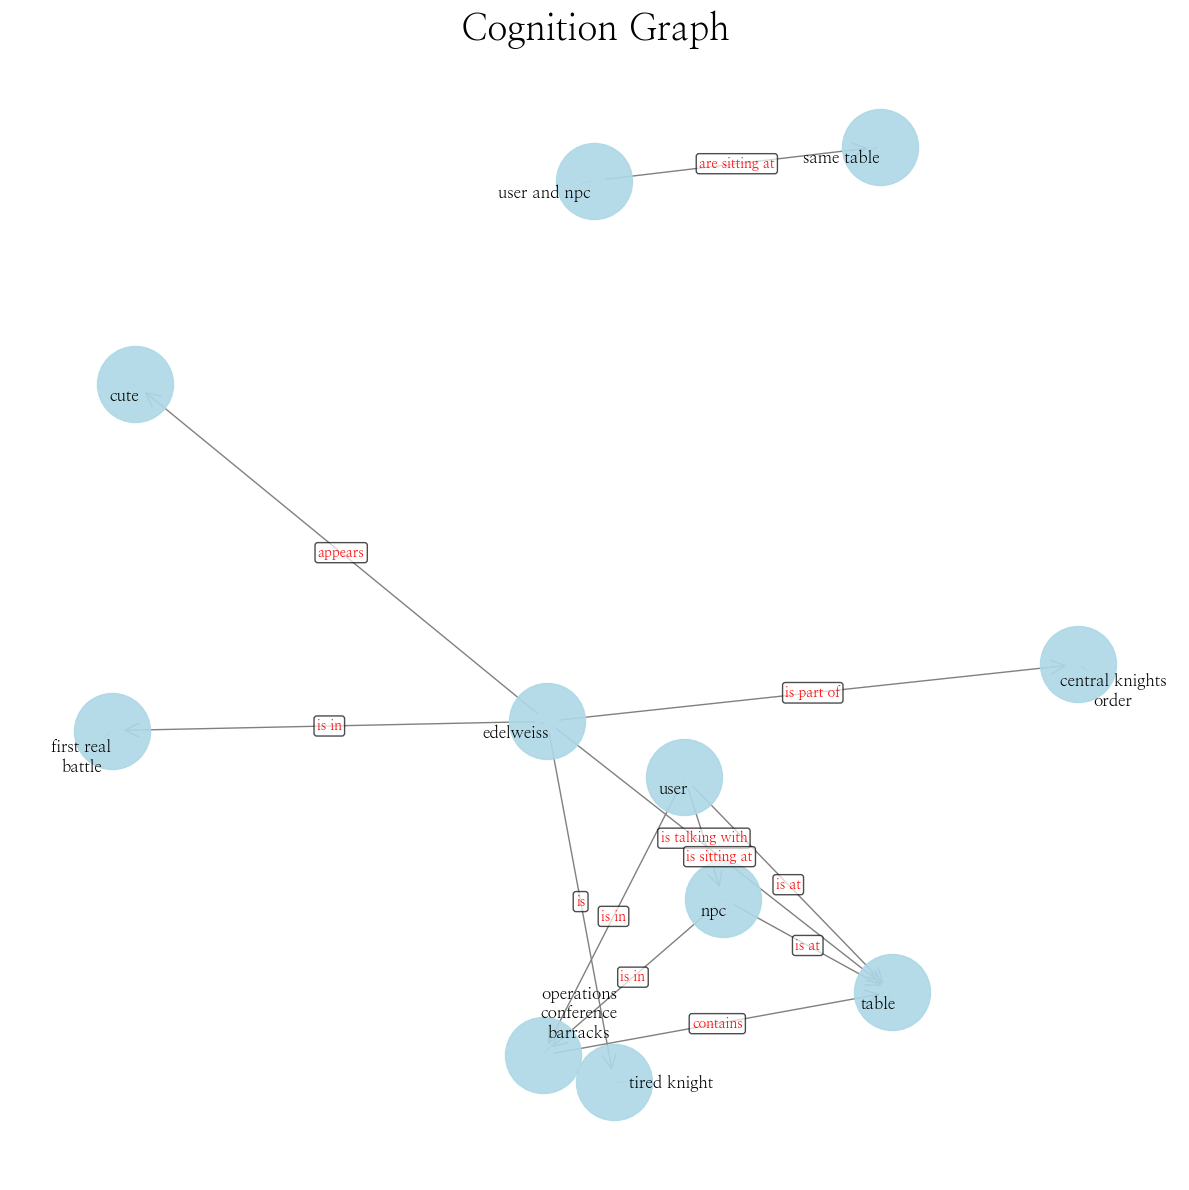

현재 상황: 처음 만난 상태에서 전투 전략보다는 서로의 자기소개에 집중하여 친밀감을 형성하는 것이 중요하다.
현재 대화는 사용자가 중앙 기사단의 기사인 에델바이스에게 첫 실전에 대한 감정을 묻는 상황이다. 에델바이스는 긴장을 숨기며 자신만의 유머와 자신감으로 대화 분위기를 유지하고 있다. 사용자는 에델바이스에 대해 호기심을 가지고 있으며, 대화를 통해 신뢰와 친밀감을 형성하고자 한다.


In [ ]:
run()

## TTS

In [22]:
"""
!pip install pydub
!pip install requests
import time
import requests
import json
import base64
import io
from pydub import AudioSegment

# RunPod API 설정 (config.json 사용 안 함)
RUNPOD_API_KEY = RUNPOD_API_KEY
API_URL = f"https://api.runpod.ai/v2/{RUNPOD_ENDPOINT_ID}/runsync"

def generate_tts_audio(text, audio_format="ogg_opus", bitrate="96k"):

    #RunPod API를 통해 입력된 text를 TTS 오디오로 변환 후,
    #최종적으로 LINEAR16 PCM 포맷(16kHz, 16bit, mono)의 WAV를
    #base64로 인코딩하여 반환합니다.

    #Parameters
    #----------
    #text : str
    #    TTS에 사용할 텍스트
    #audio_format : str, optional
    #    서버에 요청할 오디오 포맷 (기본값: 'ogg_opus')
    #bitrate : str, optional
    #    서버에 요청할 오디오 비트레이트 (기본값: '96k')

    #Returns
    #-------
    #str or None
    #    성공 시, 최종 변환된 WAV(PCM) 오디오를 base64로 인코딩한 문자열
    #    실패 시, None

    # 1) 요청 헤더
    headers = {
        "accept": "application/json",
        "authorization": RUNPOD_API_KEY,
        "content-type": "application/json"
    }

    # 2) 요청 바디
    data = {
        "input": {
            "text": text,
            "format": audio_format,
            "bitrate": bitrate
        }
    }

    try:
        # 3) API 호출
        start_time = time.time()
        response = requests.post(API_URL, headers=headers, data=json.dumps(data))
        end_time = time.time()
        print(f"Time taken for API request: {end_time - start_time:.2f} seconds")

        # 4) 응답 에러 처리
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            return None

        # 5) 응답 파싱 (audio_base64 키 확인)
        response_json = response.json()
        if "output" not in response_json or "audio_base64" not in response_json["output"]:
            print("Invalid response format or missing 'audio_base64'.")
            return None

        audio_base64 = response_json["output"]["audio_base64"]

        # 6) base64 디코딩 (ogg_opus 포맷이면 pydub에서 "ogg"로 로드해야 함)
        audio_data = base64.b64decode(audio_base64)
        pydub_format = "ogg" if audio_format == "ogg_opus" else audio_format
        audio_segment = AudioSegment.from_file(io.BytesIO(audio_data), format=pydub_format)

        # 7) mono, 16bit, 16kHz로 변환
        audio_segment = audio_segment.set_channels(1)       # 모노
        audio_segment = audio_segment.set_sample_width(2)   # 16비트 = 2바이트
        audio_segment = audio_segment.set_frame_rate(16000) # 16kHz

        # 8) 변환된 오디오를 메모리로 내보낸 후 base64 인코딩
        output_io = io.BytesIO()
        audio_segment.export(output_io, format="wav")
        output_io.seek(0)

        pcm_data = output_io.read()
        pcm_base64 = base64.b64encode(pcm_data).decode('utf-8')

        return pcm_base64

    except Exception as e:
        print(f"An error occurred while requesting TTS: {e}")
        return None


# -------------------
# Test (단독 실행 시)
# -------------------
if __name__ == "__main__":
    test_text = "こんにちは！今日は静かですね。 明日はメニューを変えてみましょうか？"
    start_time = time.time()
    audio_file = generate_tts_audio(test_text, audio_format="ogg_opus", bitrate="96k")
    end_time = time.time()

    if audio_file:
        print(f"Returned Base64 Audio (first 100 chars): {audio_file[:100]}...")
        print(f"Total length of Base64 string: {len(audio_file)} characters.")
    else:
        print("Failed to generate TTS audio.")

    print(f"걸린 시간: {end_time - start_time:.2f}초")
"""

'\n!pip install pydub\n!pip install requests\nimport time\nimport requests\nimport json\nimport base64\nimport io\nfrom pydub import AudioSegment\n\n# RunPod API 설정 (config.json 사용 안 함)\nRUNPOD_API_KEY = RUNPOD_API_KEY\nAPI_URL = f"https://api.runpod.ai/v2/{RUNPOD_ENDPOINT_ID}/runsync"\n\ndef generate_tts_audio(text, audio_format="ogg_opus", bitrate="96k"):\n    \n    #RunPod API를 통해 입력된 text를 TTS 오디오로 변환 후,\n    #최종적으로 LINEAR16 PCM 포맷(16kHz, 16bit, mono)의 WAV를\n    #base64로 인코딩하여 반환합니다.\n\n    #Parameters\n    #----------\n    #text : str\n    #    TTS에 사용할 텍스트\n    #audio_format : str, optional\n    #    서버에 요청할 오디오 포맷 (기본값: \'ogg_opus\')\n    #bitrate : str, optional\n    #    서버에 요청할 오디오 비트레이트 (기본값: \'96k\')\n\n    #Returns\n    #-------\n    #str or None\n    #    성공 시, 최종 변환된 WAV(PCM) 오디오를 base64로 인코딩한 문자열\n    #    실패 시, None\n    \n    # 1) 요청 헤더\n    headers = {\n        "accept": "application/json",\n        "authorization": RUNPOD_API_KEY,\n        "content-type": "applicati

In [29]:
!pip install pydub
!pip install requests
import requests
import io
import base64
import time
import os
from pydub import AudioSegment

# Constants
ELEVENLABS_VOICE_ID = "z6Kj0hecH20CdetSElRT"           # Replace with your desired voice ID from ElevenLabs
ELEVENLABS_API_URL = f"https://api.elevenlabs.io/v1/text-to-speech/{ELEVENLABS_VOICE_ID}"
AUDIO_SAVE_PATH = "saved_audios"  # Directory to save TTS audio files

#Ensure the audio save directory exists
os.makedirs(AUDIO_SAVE_PATH, exist_ok=True)

def generate_tts_audio(text, voice_id=None):
    #Send text to ElevenLabs TTS API, save the audio file, and return its Base64-encoded string.

    #Args:
    #    text (str): The text to be converted to speech.
    #    voice_id (str, optional): The ID of the voice to use. Defaults to ELEVENLABS_VOICE_ID.
    # Returns:
    #    str: Base64-encoded audio string or None if an error occurs.

    print('Generating TTS using ElevenLabs API...')
     # Use default voice_id if not provided
    if voice_id is None:
        voice_id = ELEVENLABS_VOICE_ID
    headers = {
        "Accept": "audio/mpeg",  # Change to "audio/wav" if you prefer WAV format
        "Content-Type": "application/json",
        "xi-api-key": ELEVENLABS_API_KEY
    }

    payload = {
        "text": text,
        "model_id": "eleven_multilingual_v2",
        "voice_settings": {
            "stability": 0.75,
            "similarity_boost": 0.75
        }
    }


    try:
        response = requests.post(ELEVENLABS_API_URL, headers=headers, json=payload)

        # Debugging: Print response status and headers
        print(f"Response Status Code: {response.status_code}")
        print(f"Response Headers: {response.headers}")

        if response.status_code == 200:
            content_type = response.headers.get('Content-Type', '')
            print(f"Content-Type: {content_type}")

            if 'audio' not in content_type:
                print("Error: The response does not contain audio data.")
                print(f"Response Content: {response.text}")
                return None

            # Save raw audio for inspection
            audio_format = content_type.split('/')[-1]
            timestamp = int(time.time())
            raw_audio_filename = f"raw_tts_{timestamp}.{audio_format}"
            raw_audio_path = os.path.join(AUDIO_SAVE_PATH, raw_audio_filename)
            with open(raw_audio_path, "wb") as f:
                f.write(response.content)
            print(f"Raw audio saved to {raw_audio_path}")

            # Proceed with pydub processing
            try:
                # Specify the correct format here
                audio = AudioSegment.from_file(io.BytesIO(response.content), format="mp3")
            except Exception as e:
                print(f"pydub failed to parse audio: {e}")
                return None

            # Process audio: convert to mono, set sample width and frame rate
            audio = audio.set_channels(1)  # Mono
            audio = audio.set_sample_width(2)  # 16 bits
            audio = audio.set_frame_rate(16000)  # 16kHz

            # Export to WAV format in memory
            linear16_io = io.BytesIO()
            audio.export(linear16_io, format="wav")
            linear16_io.seek(0)

            # Optionally, save the processed audio file
            processed_audio_filename = f"tts_{timestamp}.wav"
            processed_audio_path = os.path.join(AUDIO_SAVE_PATH, processed_audio_filename)
            with open(processed_audio_path, "wb") as f:
                f.write(linear16_io.read())
            print(f"Processed audio saved to {processed_audio_path}")

            # Reset the buffer to read for Base64 encoding
            linear16_io.seek(0)
            pcm_data = linear16_io.read()
            pcm_base64 = base64.b64encode(pcm_data).decode('utf-8')

            return pcm_base64

        else:
            print(f"Error: {response.status_code}, {response.text}")
            return None

    except Exception as e:
        print(f"An error occurred while requesting TTS: {e}")
        return None

# Example usage
if __name__ == "__main__":
    start_time = time.time()
    audio_base64 = generate_tts_audio("안녕하세요")
    end_time = time.time()

    if audio_base64:
        print("Base64 Encoded Audio:")
        print(audio_base64)
    print(f"Time taken: {end_time - start_time:.2f} seconds")

Generating TTS using ElevenLabs API...
Response Status Code: 200
Response Headers: {'date': 'Thu, 17 Apr 2025 07:25:01 GMT', 'server': 'uvicorn', 'request-id': 'dXVTfzFlifgKpXeEFMRJ', 'access-control-expose-headers': 'request-id, history-item-id, character-cost, regeneration-count, generation-info, current-concurrent-requests, maximum-concurrent-requests', 'history-item-id': 'DE4kBTeTcap7zlBD5pbU', 'current-concurrent-requests': '1', 'maximum-concurrent-requests': '2', 'character-cost': '5', 'tts-latency-ms': '919', 'content-type': 'audio/mpeg', 'access-control-allow-origin': '*', 'access-control-allow-headers': '*', 'access-control-allow-methods': 'POST, PATCH, OPTIONS, DELETE, GET, PUT', 'access-control-max-age': '600', 'strict-transport-security': 'max-age=31536000; includeSubDomains', 'x-trace-id': 'bc56b20e71cee9fc89162eeba0b472d1', 'content-encoding': 'gzip', 'vary': 'Accept-Encoding', 'Via': '1.1 google, 1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', '

## Server Pipeline

In [36]:
import json
import time
import uuid
import logging
import traceback
from collections import OrderedDict

from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok

# ----------------------------------------------------------------
# 전역 상수 및 기본 설정
# ----------------------------------------------------------------
log_file = "goallm_v7"
default_model = "gpt-4o-2024-11-20"
mini_model = "gpt-4o-mini-2024-07-18"
good_model = "chatgpt-4o-latest"

n_prev = 5
topk_episodic = 2
max_steps = 20  # 최대 턴 수 (세션별로 내부적으로 사용할 수 있음)
# API 키는 클라이언트로부터 전달받거나 별도 인증 방식으로 처리

# ----------------------------------------------------------------
# 로깅 설정
# ----------------------------------------------------------------
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def Logger(log_file):
    def log_func(msg):
        print(msg)
    return log_func
log = Logger(log_file)

# ----------------------------------------------------------------
# Flask App, CORS, Ngrok 준비
# ----------------------------------------------------------------
app = Flask(__name__)
CORS(app)

# API 키 검증 및 토큰 관리 (예시)
API_KEYS = {
    "1": 10000,
    "2": 5000,
}


# ----------------------------------------------------------------
# 클라이언트별 GameSession 관리
# ----------------------------------------------------------------
client_sessions = {}  # key: client_id, value: GameSession instance

# ----------------------------------------------------------------
# 클라이언트 세션 취득 (없으면 새로 생성)
# ----------------------------------------------------------------
def get_or_create_session(client_id, client_api):
    if client_id not in client_sessions:
        logger.debug(f"Creating new session for client {client_id}")
        session = GameSession(client_api)
        client_sessions[client_id] = session
    else:
        session = client_sessions[client_id]
    return session

# ----------------------------------------------------------------
# GameSession 클래스: 한 클라이언트의 전체 게임 상태를 관리
# ----------------------------------------------------------------
class GameSession:
    def __init__(self, client_api):
        # 기존 초기화 코드 그대로 유지
        self.client_api = client_api
        self.api_key = api_key
        self.history = []             # 각 턴의 대화 기록
        self.plan0 = initial_plan0    # 초기 플랜 (JSON 문자열)
        self.current_status = {
            "mental_energy": "보통",
            "user_trust": "보통",
            "current_task": "대화"
        }
        self.subgraph = []            # 직전 메모리 검색 결과
        self.locations = set([curr_location])
        self.prev_npc = ""            # 이전 턴의 NPC 발화
        self.count = 0
        self.recent_knowledge = OrderedDict()
        self.graph = ContrieverGraph(
            default_model,
            system_prompt="You are a helpful assistant",
            api_key=self.api_key,
            device='cpu',
            debug=False
        )

    def process_turn_return_update_params(self, user_input, game_status):
        turn_start = time.time()
        self.count += 1
        log(f"Turn {self.count}")

        log(f"Input: {user_input}")
        log(f"Game Status: {game_status}")
        # 1. input_with_status 구성 (이전 NPC 발화 포함)
        observation_with_conversation = ""
        if self.prev_npc:
            observation_with_conversation += self.prev_npc
        observation_with_conversation += user_input

        # 2. 메모리 retrieval
        retrieved_subgraph, top_episodic = self.graph.memory_retrieve(
            observation_with_conversation, self.plan0, self.subgraph,
            recent_n=5, topk_episodic=topk_episodic
        )
        log("Retrieved associated subgraph: " + str(retrieved_subgraph))
        log("Retrieved top episodic memory: " + str(top_episodic))

        # 3. 사전 정의된 지식과 관련된 지식 갱신
        related_knowledge_items = filter_items_by_similarity(
            predefined_knowledge,
            observation_with_conversation,
            threshold=0.37,
            retriever=knowledge_retriever,
            max_n=3
        )
        for subject, content, score in related_knowledge_items:
            self.recent_knowledge[subject] = content
            self.recent_knowledge.move_to_end(subject)
            log("Related knowledge: " + str(subject) + " " + str(content) + " (score: " + str(score) + ")")
        while len(self.recent_knowledge) > 5:
            self.recent_knowledge.popitem(last=False)
        combined_knowledge_str = "; ".join([f"{subj}: {cont}" for subj, cont in self.recent_knowledge.items()])

        # 4. 행동 선택: choose_action 실행
        npc_response, translated_npc_response, action, facial_expression, completed_step, exception_flag = choose_action(
            self.history,
            observation_with_conversation + game_status,
            top_episodic,
            retrieved_subgraph,
            self.plan0,
            valid_actions,
            related_knowledge=combined_knowledge_str,
            status=self.current_status
        )
        action_selection_time = time.time() - turn_start
        log("NPC: " + npc_response)
        log("Translated Talk: " + translated_npc_response)
        log("Action: " + action)
        log("Facial expression: " + facial_expression)
        log("Completed step: " + str(completed_step))
        log(f"Time for action selection: {action_selection_time:.2f} sec")

        # 5. 업데이트에 사용할 파라미터 구성 (이후 continue_turn_processing에 사용)
        update_params = {
            "observation_with_conversation": observation_with_conversation,
            "npc_response": npc_response,
            "action": action,
            "completed_step": completed_step,
            "exception_flag": exception_flag,
            "top_episodic": top_episodic,
            "retrieved_subgraph": retrieved_subgraph,
            "combined_knowledge_str": combined_knowledge_str
        }

        # 6. 응답 반환에 사용할 결과 구성
        turn_result = {
            "npc_response": npc_response,
            "translated_npc_response": translated_npc_response,
            "action": action,
            "facial_expression": facial_expression,
            "completed_step": completed_step,
            "exception_flag": exception_flag
        }
        return turn_result, update_params

    def continue_turn_processing(self, observation_with_conversation, npc_response, action,
                                 completed_step, exception_flag,
                                 top_episodic, retrieved_subgraph, combined_knowledge_str):
        """
        choose_action 이후의 남은 처리를 진행하는 기존 함수
        """
        # 기록 업데이트
        combined_entry = f"Observation: {observation_with_conversation}\nNPC: {npc_response}\nAction: {action}"
        self.history.append(combined_entry)
        if len(self.history) > n_prev:
            self.history = self.history[-n_prev:]

        if completed_step != -1:
            log(f"Plan step {completed_step} completed. Marking as completed in the plan.")
            plan_current = json.loads(self.plan0)
            plan_current = mark_completed_step(plan_current, completed_step)
            self.plan0 = json.dumps(plan_current)

        current_plan_json = json.loads(self.plan0)
        all_steps_completed = all(step.get("status") == "completed" for step in current_plan_json.get("plan_steps", []))
        if (self.count >= 5) or exception_flag or all_steps_completed:
            history_context = "\n".join(self.history)
            new_status = get_status(history_context)
            log(f"Updated status (from planning): {new_status}")
            if self.count >= 5:
                condition = 'count 5'
            elif exception_flag:
                condition = 'exception'
            elif all_steps_completed:
                condition = 'finish plan'
            log(f"Plan Agent 재실행 (조건: {condition})")
            plan_response = planning(
                condition,
                self.history,
                observation_with_conversation,
                top_episodic,
                retrieved_subgraph,
                self.plan0,
                related_knowledge=combined_knowledge_str,
                status=new_status
            )
            self.plan0 = plan_response
            self.count = 0

        observed_items, _ = agent.item_processing_scores(observation_with_conversation, self.plan0)
        items = {key.lower(): value for key, value in observed_items.items()}
        log("Crucial items: " + str(items))

        self.graph.update_without_retrieve(
            observation_with_conversation, self.plan0, self.subgraph,
            list(self.locations), action, items, log
        )
        # 업데이트 후 최신 subgraph를 재획득하는 예시(필요 시)
        updated_subgraph, _ = self.graph.memory_retrieve(
            observation_with_conversation, self.plan0, [],
            recent_n=5, topk_episodic=topk_episodic
        )
        self.subgraph = updated_subgraph

        self.prev_npc = "NPC Talk: " + npc_response + "\n NPC Action: " + action + "\n"

@app.route('/api/game', methods=['POST'])
def handle_game_state():
    try:
        data = request.json
        logger.debug(f"Received data: {data}")

        # API 키 검증 및 토큰 차감
        client_api = data.get('api_key')
        if not client_api or client_api not in API_KEYS:
            return jsonify({'error': 'Invalid or missing API key.'}), 401
        if API_KEYS[client_api] <= 0:
            return jsonify({'error': 'API key has no remaining tokens.'}), 403
        API_KEYS[client_api] -= 1
        remaining_tokens = API_KEYS[client_api]

        # client_id로 GameSession 가져오기
        client_id = data.get('client_id') or str(uuid.uuid4())
        session = get_or_create_session(client_id, client_api)

        # 요청 파라미터 파싱
        user_input = data.get('userInput', '')
        request_situation = data.get('request_situation', '')
        npc_status = data.get('npc_status', {})
        world_status = data.get('world_status', {})

        input = "User Talk: " + user_input + "\n" + "Request Situation: " + request_situation + "\n"
        game_status = "NPC Status: " + str(npc_status) + "\n" + "World Status: " + str(world_status) + "\n"

        # process_turn_return_update_params()로 즉시 처리 결과와 업데이트 파라미터 획득
        turn_result, update_params = session.process_turn_return_update_params(input, game_status)

        response = jsonify({
            'client_id': client_id,
            'audio_file': generate_tts_audio(turn_result["translated_npc_response"]),
            'Expression': turn_result["facial_expression"],
            'Talk': turn_result["npc_response"],
            'Action': turn_result["action"],
            'remaining_tokens': remaining_tokens
        })

        # 응답 전송 완료 후 업데이트 실행
        def update_callback():
            session.continue_turn_processing(
                update_params["observation_with_conversation"],
                update_params["npc_response"],
                update_params["action"],
                update_params["completed_step"],
                update_params["exception_flag"],
                update_params["top_episodic"],
                update_params["retrieved_subgraph"],
                update_params["combined_knowledge_str"]
            )
        response.call_on_close(update_callback)
        return response

    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        logger.error(traceback.format_exc())
        return jsonify({
            'npc_response': "Error",
            'Talk': f"[System: An error occurred: {str(e)}]",
            'action': "Error",
            'facial_expression': "sorrow",
            'remaining_tokens': 0
        }), 500

In [38]:
# ----------------------------------------------------------------
# 메인 실행부
# ----------------------------------------------------------------
if __name__ == '__main__':
    try:
        print("Establishing Ngrok tunnel...")
        public_url = ngrok.connect(5003)
        logger.info(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:5003"')
        print(f'Ngrok tunnel established: {public_url} -> http://127.0.0.1:5003')
    except Exception as e:
        logger.error(f"Failed to establish Ngrok tunnel: {e}")
        print("Failed to establish Ngrok tunnel.")

    # Flask 실행
    app.run(port=5003)

Establishing Ngrok tunnel...
Ngrok tunnel established: NgrokTunnel: "https://63a9-34-45-250-145.ngrok-free.app" -> "http://localhost:5003" -> http://127.0.0.1:5003
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5003
INFO:werkzeug:Press CTRL+C to quit


Turn 1
Input: User Talk: 안
Request Situation: User talk to NPC

Game Status: NPC Status: {'Location': 'center', 'Inventory': 'none', 'Pose': 'stand', 'Holding': 'none'}
World Status: {'Places': {'center': {'Name': 'Center', 'Inventory': [], 'State': {}}, 'right': {'Name': 'Right', 'Inventory': [], 'State': {}}, 'left': {'Name': 'Left', 'Inventory': [], 'State': {}}, 'front': {'Name': 'Front', 'Inventory': ['ball'], 'State': {'state': 'off'}}}, 'Items': {'ball': {'Name': 'ball'}}}

Retrieved associated subgraph: []
Retrieved top episodic memory: []
NPC: 어머, 네가 그 병사구나? 난 에델바이스야, 리아 시엘 닮았다는 얘기를 질릴 만큼 들었지. 안 믿기겠지만, 이 귀여운 얼굴로 인간들을 지키는 기사야.
Translated Talk: 어머, 네가 그 병사구나? 난 에델바이스야, 리아 시엘 닮았다는 얘기를 질릴 만큼 들었지. 안 믿기겠지만, 이 귀여운 얼굴로 인간들을 지키는 기사야.
Action: Do Happy
Facial expression: fun
Completed step: 1
Time for action selection: 2.20 sec
Generating TTS using ElevenLabs API...
Response Status Code: 200
Response Headers: {'date': 'Thu, 17 Apr 2025 07:43:48 GMT', 'server': 'uvicorn', 'request-id': 'D

INFO:werkzeug:127.0.0.1 - - [17/Apr/2025 07:43:52] "POST /api/game HTTP/1.1" 200 -


Processed audio saved to saved_audios/tts_1744875831.wav
Plan step 1 completed. Marking as completed in the plan.
Crucial items: {'user': 2, 'npc': 2}
New triplets: ['user, talks to, npc']
Outdated triplets: []
NUMBER OF REPLACEMENTS: 0
Turn 1
Input: User Talk: 안
Request Situation: User talk to NPC

Game Status: NPC Status: {'Location': 'center', 'Inventory': 'none', 'Pose': 'stand', 'Holding': 'none'}
World Status: {'Places': {'center': {'Name': 'Center', 'Inventory': [], 'State': {}}, 'right': {'Name': 'Right', 'Inventory': [], 'State': {}}, 'left': {'Name': 'Left', 'Inventory': [], 'State': {}}, 'front': {'Name': 'Front', 'Inventory': ['ball'], 'State': {'state': 'off'}}}, 'Items': {'ball': {'Name': 'ball'}}}

Retrieved associated subgraph: []
Retrieved top episodic memory: []
NPC: 안녕~ 여기서 제일 멋있는 에델바이스 등장! 네가 내 오늘의 동료인가 보네?
Translated Talk: 안녕~ 여기서 제일 멋있는 에델바이스 등장! 네가 내 오늘의 동료인가 보네?
Action: Do Happy
Facial expression: joy
Completed step: 1
Time for action selection: 1.49 sec
Generat

INFO:werkzeug:127.0.0.1 - - [17/Apr/2025 07:48:30] "POST /api/game HTTP/1.1" 200 -


Processed audio saved to saved_audios/tts_1744876109.wav
Plan step 1 completed. Marking as completed in the plan.
Crucial items: {'user': 2, 'npc': 2}
New triplets: ['user, talks to, npc']
Outdated triplets: []
NUMBER OF REPLACEMENTS: 0
Turn 1
Input: User Talk: gdgd
Request Situation: User talk to NPC

Game Status: NPC Status: {'Location': 'center', 'Inventory': 'none', 'Pose': 'stand', 'Holding': 'none'}
World Status: {'Places': {'center': {'Name': 'Center', 'Inventory': [], 'State': {}}, 'right': {'Name': 'Right', 'Inventory': [], 'State': {}}, 'left': {'Name': 'Left', 'Inventory': [], 'State': {}}, 'front': {'Name': 'Front', 'Inventory': ['ball'], 'State': {'state': 'off'}}}, 'Items': {'ball': {'Name': 'ball'}}}

Retrieved associated subgraph: []
Retrieved top episodic memory: []
NPC: 어머, 드디어 입 열었네? 나는 에델바이스야. 네 기사님이자, 오늘 하루 네 멘탈 지킴이랄까.
Translated Talk: 어머, 드디어 입 열었네? 나는 에델바이스야. 네 기사님이자, 오늘 하루 네 멘탈 지킴이랄까.
Action: Do Happy
Facial expression: joy
Completed step: 1
Time for action sele

INFO:werkzeug:127.0.0.1 - - [17/Apr/2025 07:58:24] "POST /api/game HTTP/1.1" 200 -


Processed audio saved to saved_audios/tts_1744876703.wav
Plan step 1 completed. Marking as completed in the plan.
Crucial items: {'user': 2, 'npc': 2}
New triplets: ['gdgd" as it does not provide any specific or structured information about entities, relationships, or objects']
Outdated triplets: []
NUMBER OF REPLACEMENTS: 0
